## This code illustrates the fast AI implementation of the unsupervised "biological" learning algorithm from [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116) on faces data set (gender recognition).

## Imports and Parameters

In [154]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

This cell defines paramaters of the algorithm: 
- `eps0`: initial learning rate that is linearly annealed during training
- `N_hid`: number of hidden units that are displayed as an `Ky` by `Kx` array by the `draw_weights` function defined below
- `mu`: the mean of the gaussian distribution that initializes the weights
- `sigma`: the standard deviation of that gaussian 
- `Nep`: number of epochs
- `N_batch`: size of the minibatch
- `prec`: parameter that controls numerical precision of the weight updates
- `delta`: the strength of the anti-hebbian learning
- `p`: Lebesgue norm of the weights; `k` - ranking parameter. 
- `N_in`: number of input units
- `val_split`: the proportion of validation split

In [143]:
eps0 = 4e-2    # initial learning rate for the unsupervised part
Kx = 5
Ky = 5
hid_disp = Kx*Ky    # number of hidden units that are displayed in Ky by Kx array
N_hid = 1000    # number of hidden units
mu = 0.0
sigma = 1.0
Nep = 100     # number of epochs
N_batch = 100  # size of the minibatch
prec = 1e-30
delta = 0.5    # Strength of the anti-hebbian learning
p = 2.5       # Lebesgue norm of the weights
k = 2          # ranking parameter, must be integer that is bigger or equal than 2

N_in = 2304     # input units
Nc = 2        # number of classes
val_split = 0.125

In [144]:
# a utility function to shuffle training and testing samples
def shuffle(xt, yt, xv, yv):
    
    # xt, yt: training samples and labels
    # xv, yv: validation samples and labels
    
    pt = np.random.permutation(len(xt))
    pv = np.random.permutation(len(xv))
    return(xt[pt], yt[pt], xv[pv], yv[pv])

## Data
Let's load data:
- Shuffle them
- Normalize to \[0, 1\] range
- Reshape images to (#samples, 2304) and labels to (#samples, 2)
- Split the train part to 18149 train and 2539 validation samples

In [ ]:
! pip install opendatasets --upgrade
import opendatasets as od

dataset_url = 'https://www.kaggle.com/nipunarora8/age-gender-and-ethnicity-face-data-csv'
od.download('https://www.kaggle.com/nipunarora8/age-gender-and-ethnicity-face-data-csv')

In [145]:
data = pd.read_csv(r"C:\Users\Яна\labs\CompVP project\age_gender.csv")
data

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...
...,...,...,...,...,...
23700,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...


In [146]:
data_csv = pd.DataFrame(data)
data_csv['pixels']=data_csv['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))
img_data = np.array(data_csv['pixels'].tolist())
print(img_data.shape)

(23705, 2304)


In [147]:
X = img_data
y = np.array(data_csv["gender"].astype('category'))
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=val_split, random_state=42)

# shuffle
x_train, y_train, x_test, y_test = shuffle(x_train, y_train, x_test, y_test)

# normalize
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# indices of validation splilt
val_idx = np.random.choice(x_train.shape[0], int(val_split * x_train.shape[0]), replace=False)

#split validation
x_val = x_train[val_idx]
y_val = y_train[val_idx]
x_train = np.delete(x_train, val_idx, axis=0)
y_train = np.delete(y_train, val_idx, axis=0)
y_train_one = y_train
y_test_one = y_test
y_val_one = y_val_one

# some logging
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, Nc)
y_val = keras.utils.to_categorical(y_val, Nc)
y_test = keras.utils.to_categorical(y_test, Nc)

x_train shape: (18149, 2304)
y_train shape: (18149,)
x_val shape: (2592, 2304)
y_val shape: (2592,)
18149 train samples
2964 test samples


In [148]:
N_train = x_train.shape[0]
N_val = x_val.shape[0]
N_test = x_test.shape[0]

## Weights visualization
To draw a heatmap of the weights a helper function is created:

In [197]:
def draw_weights(synapses, Kx, Ky, num_file=-1, ax=None):
    # synapses: the weights
    yy=0
    HM=np.zeros((48*Ky,48*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*48:(y+1)*48,x*48:(x+1)*48]=synapses[yy,:].reshape(48,48)
            yy += 1
   
    nc=np.amax(np.absolute(HM))
    
    if ax is not None:
        im = ax.imshow(HM, cmap='bwr', vmin=-nc, vmax = nc)
        fig.colorbar(im, ticks=[np.amin(HM), 0, np.amax(HM)], ax=ax)
        ax.axis('off')
    else:
        plt.clf()
        im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
        fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
        plt.axis('off')
    
    if num_file > -1:
        file_name = '../CompVP project/face-gender-2ch/' + str(num_file) + '.png'
        plt.savefig(file_name)
    fig.canvas.draw() 

## Forward pass of the unsupervised part
This is one step of the training and returns the changes that should be applied to the weights in one iteration. 

**Note:** In the testing phase, we don't need to compute `h` or `g` functions, so we just return the input currents.
- Given the inputs and the synapses (weights), compute the input currents `tot_input` = <W.v>
    - This is referred to `I` in the paper.
- If we're in the testing phase, return `tot_input`
- If we're in the training phase, go on to use the rankings in the input currents as proxies for the final `h` and return the changes that should be application 

In [150]:
def forward(inputs, synapses, p, N_hid, N_batch, N_in, training=True):
    inputs = np.transpose(inputs)
    sig=np.sign(synapses)
    tot_input=np.dot(sig*np.absolute(synapses)**(p-1),inputs) # with p=2, this is equal to <W.v> = I 
    

    if training == False:
        return tot_input.T
    
    # TODO: compute h...
    
    y=np.argsort(tot_input,axis=0) # using tot_input (I) as proxy for h
    yl=np.zeros((N_hid, N_batch)) # y1 = g(Q)
    yl[y[N_hid-1],np.arange(N_batch)]=1.0 # g(max_activation in I) = 1
    yl[y[N_hid-k],np.arange(N_batch)]=-delta # g(second max activation) = -0.4
#     if training == False:
#         return yl.T
    xx=np.sum(np.multiply(yl,tot_input),1) # g(Q) x <W, v>
    ds=np.dot(yl,np.transpose(inputs)) - np.multiply(np.tile(xx.reshape(xx.shape[0],1),(1,N_in)),synapses)
    # g(Q) (v_i - <W,v> W_i)
    nc=np.amax(np.absolute(ds))
    return ds, nc

## The unsupervised training of the hidden layer
This cell defines the main code. The external loop runs over epochs `nep`, the internal loop runs over minibatches. For every minibatch the overlap with the data `tot_input` is calculated for each data point and each hidden unit. The sorted strengths of the activations are stored in `y`. The variable `yl` stores the activations of the post synaptic cells - it is denoted by g(Q) in Eq 3 of [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116), see also Eq 9 and Eq 10. The variable `ds` is the right hand side of Eq 3. The weights are updated after each minibatch in a way so that the largest update is equal to the learning rate `eps` at that epoch. The weights are displayed by the helper function after each epoch. 

### Note
This will take some time, especially if the hidden layer is big (e.g. N_hid>500). If you want to see a demo, skip to the next cell to load the pre-trained weights.

If you do train the model yourself, make sure to comment the next cell so you don't replace the your trained weights with the pre-trained ones!

<IPython.core.display.Javascript object>


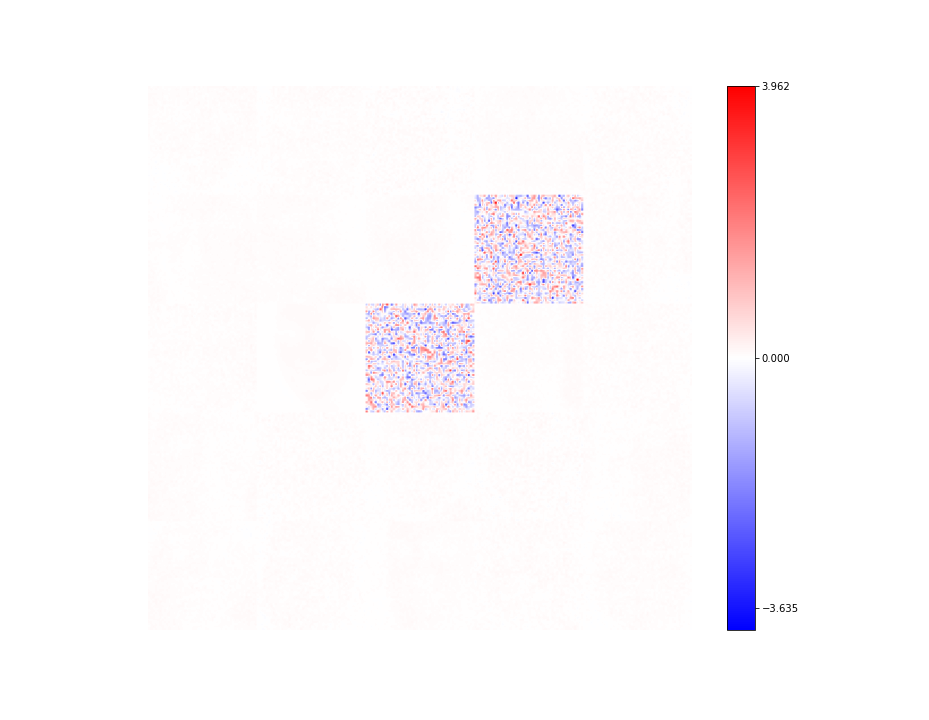

(1000, 2304)


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:47:40<00:00, 64.60s/it]


In [199]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))

num_file = 0
synapses = np.random.normal(mu, sigma, (N_hid, N_in)) # W
print(synapses.shape)
for nep in tqdm(range(Nep)):
    eps=eps0*(1-nep/Nep)
    for i in range(N_train//N_batch):
        inputs=x_train[i*N_batch:(i+1)*N_batch,:] # v_i 
        ds, nc = forward(inputs, synapses, p, N_hid, N_batch, N_in)
        if nc<prec:
            nc=prec
        synapses += eps*np.true_divide(ds,nc)
        
    draw_weights(synapses, Kx, Ky, num_file)
    num_file += 1

## Saving or loading synapses
- If you want to save your own synapses from previous cell, uncomment and edit the first line
- If you want to load a pre-trained model, use the `np.load` function in the second line

A sample `synapses.npy` file can be found [here](https://drive.google.com/file/d/1NXwLlaJIQypYWg9TDsday3lrqo_79MSp/view?usp=sharing)


In [172]:
# save your own model
# np.save('FaceGender_new_synapses_hid1000_epoch100_eps4e-2_p2.5_k2_batch100_delta_0.5.npy', synapses)

# load a pre-trained model
synapses = np.load('FaceGender_new2_synapses_hid1000_epoch100_eps4e-2_p2.5_k2_batch100_delta_0.5.npy')
synapses.shape

(1000, 2304)

<IPython.core.display.Javascript object>


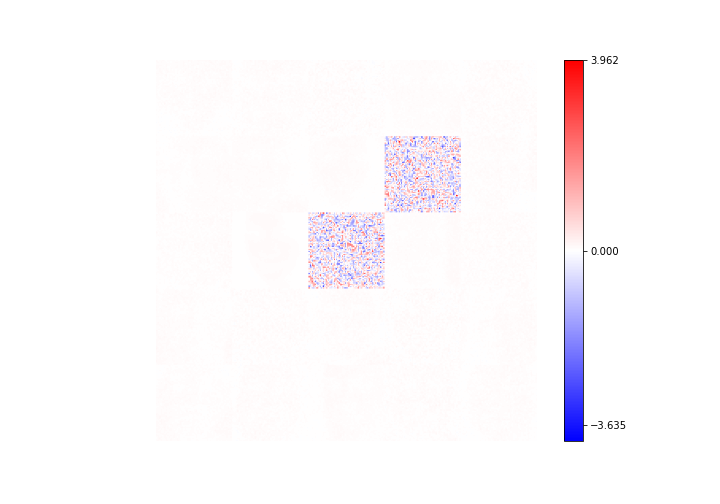

In [201]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(10, 7))
draw_weights(synapses, Kx, Ky)

In [202]:
synapses.min()
syn_list = synapses.ravel()
syn_count = np.prod(synapses.shape)
print('Number of weights:', syn_count)
nonzero_count = np.count_nonzero(synapses)
print('Number of zero weights:', syn_count-nonzero_count)
nonzero_proportion = nonzero_count/syn_count
print('Proportion of zero weights', nonzero_proportion.round(2))
negative_count = np.count_nonzero(synapses<0)
print('Negative weights count:', negative_count)
positive_count = np.count_nonzero(synapses>0)
print('Positive weights count:', positive_count)

Number of weights: 2304000
Number of zero weights: 0
Proportion of zero weights 1.0
Negative weights count: 301158
Positive weights count: 2002842


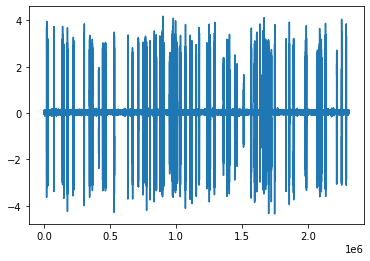

In [203]:
%matplotlib inline
plt.plot(syn_list)
plt.show()

In [204]:
def normalize(x):
    x_norm = x - x.mean(axis=1, keepdims=True)
    x_norm = x_norm / np.linalg.norm(x_norm, ord=2, axis=1, keepdims=True)
    return x_norm

## Testing: compute hidden neurons for train, val, and test data
This will be the input to the second layer, which will be trained with SGD to do digit recognition.

In [205]:
# Center and normalize input data to unit vectors  
x_train0 = normalize(x_train)
x_val0 = normalize(x_val)
x_test0 = normalize(x_test)

x_hid_train = forward(x_train0, synapses, p, N_hid, N_train, N_in, training=False)
x_hid_val = forward(x_val0, synapses, p, N_hid, N_val, N_in, training=False)
x_hid_test = forward(x_test0, synapses, p, N_hid, N_val, N_in, training=False)

n=2
x_hid_train = (x_hid_train * (x_hid_train>0)) ** n
x_hid_val = (x_hid_val * (x_hid_val>0)) ** n

## Define the BIO model
- Input is the pre-computed hidden activations.
- Output layer is a fully connected layer with softmax activation
- Loss function is the categorical cross-entropy
- Optimizer is Adam with initial learning rate of 0.1 which decays exponentially every 20 epochs with a decay rate of 0.7
- Batch size is 100 and number of epochs is 100

Set `verbose=1` in the `model.fit()` function to see the loss and accuracy values after each epoch.

In [206]:
bio_model = keras.Sequential([
    layers.Input(shape=(N_hid,)),
    layers.Dense(Nc),
    layers.Activation('softmax')
])

print(bio_model.summary())

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-1, decay_steps=Nep*20, decay_rate=0.7, 
                                                          staircase=True)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
bio_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
bio_logs = bio_model.fit(x_hid_train, y_train, validation_data=(x_hid_val, y_val), batch_size=385, epochs=500, verbose=1)

Train on 18149 samples, validate on 2592 samples
Epoch 1/500
18149/18149 [==============================] - 1s 46us/sample - loss: 0.2871 - acc: 0.6716 - val_loss: 0.2696 - val_acc: 0.6937
Epoch 2/500
18149/18149 [==============================] - 1s 34us/sample - loss: 0.2622 - acc: 0.6956 - val_loss: 0.2565 - val_acc: 0.6979
Epoch 3/500
18149/18149 [==============================] - 1s 34us/sample - loss: 0.2510 - acc: 0.6975 - val_loss: 0.2818 - val_acc: 0.6628
Epoch 4/500
18149/18149 [==============================] - 1s 30us/sample - loss: 0.2705 - acc: 0.6923 - val_loss: 0.2457 - val_acc: 0.7164
Epoch 5/500
18149/18149 [==============================] - 1s 29us/sample - loss: 0.2415 - acc: 0.7085 - val_loss: 0.2335 - val_acc: 0.7033
Epoch 6/500
18149/18149 [==============================] - 1s 31us/sample - loss: 0.2307 - acc: 0.7106 - val_loss: 0.2327 - val_acc: 0.7106
Epoch 7/500
18149/18149 [==============================] - 1s 29us/sample - loss: 0.2371 - acc: 0.7094 - val_lo

18149/18149 [==============================] - 1s 30us/sample - loss: 0.1528 - acc: 0.7879 - val_loss: 0.1470 - val_acc: 0.7940
Epoch 59/500
18149/18149 [==============================] - 1s 30us/sample - loss: 0.1480 - acc: 0.7939 - val_loss: 0.1569 - val_acc: 0.7735
Epoch 60/500
18149/18149 [==============================] - 1s 30us/sample - loss: 0.1496 - acc: 0.7923 - val_loss: 0.1477 - val_acc: 0.7913
Epoch 61/500
18149/18149 [==============================] - 1s 30us/sample - loss: 0.1496 - acc: 0.7906 - val_loss: 0.1489 - val_acc: 0.7897
Epoch 62/500
18149/18149 [==============================] - 1s 30us/sample - loss: 0.1494 - acc: 0.7953 - val_loss: 0.1593 - val_acc: 0.7739
Epoch 63/500
18149/18149 [==============================] - 1s 30us/sample - loss: 0.1604 - acc: 0.7795 - val_loss: 0.1464 - val_acc: 0.7948
Epoch 64/500
18149/18149 [==============================] - 1s 30us/sample - loss: 0.1515 - acc: 0.7911 - val_loss: 0.1497 - val_acc: 0.7901
Epoch 65/500
18149/18149 [

18149/18149 [==============================] - 1s 31us/sample - loss: 0.1337 - acc: 0.8121 - val_loss: 0.1422 - val_acc: 0.7978
Epoch 116/500
18149/18149 [==============================] - 1s 31us/sample - loss: 0.1332 - acc: 0.8127 - val_loss: 0.1426 - val_acc: 0.7924
Epoch 117/500
18149/18149 [==============================] - 1s 33us/sample - loss: 0.1316 - acc: 0.8154 - val_loss: 0.1381 - val_acc: 0.7986
Epoch 118/500
18149/18149 [==============================] - 1s 36us/sample - loss: 0.1315 - acc: 0.8156 - val_loss: 0.1317 - val_acc: 0.8156
Epoch 119/500
18149/18149 [==============================] - 1s 35us/sample - loss: 0.1358 - acc: 0.8083 - val_loss: 0.1491 - val_acc: 0.7897
Epoch 120/500
18149/18149 [==============================] - 1s 34us/sample - loss: 0.1362 - acc: 0.8083 - val_loss: 0.1336 - val_acc: 0.8144
Epoch 121/500
18149/18149 [==============================] - 1s 34us/sample - loss: 0.1326 - acc: 0.8134 - val_loss: 0.1391 - val_acc: 0.8021
Epoch 122/500
18149/

18149/18149 [==============================] - 1s 30us/sample - loss: 0.1230 - acc: 0.8282 - val_loss: 0.1225 - val_acc: 0.8314
Epoch 173/500
18149/18149 [==============================] - 1s 29us/sample - loss: 0.1225 - acc: 0.8279 - val_loss: 0.1239 - val_acc: 0.8302
Epoch 174/500
18149/18149 [==============================] - 1s 30us/sample - loss: 0.1234 - acc: 0.8272 - val_loss: 0.1255 - val_acc: 0.8264
Epoch 175/500
18149/18149 [==============================] - 1s 29us/sample - loss: 0.1221 - acc: 0.8302 - val_loss: 0.1232 - val_acc: 0.8295
Epoch 176/500
18149/18149 [==============================] - 1s 30us/sample - loss: 0.1225 - acc: 0.8268 - val_loss: 0.1280 - val_acc: 0.8221
Epoch 177/500
18149/18149 [==============================] - 1s 30us/sample - loss: 0.1245 - acc: 0.8240 - val_loss: 0.1222 - val_acc: 0.8326
Epoch 178/500
18149/18149 [==============================] - 1s 29us/sample - loss: 0.1211 - acc: 0.8304 - val_loss: 0.1269 - val_acc: 0.8225
Epoch 179/500
18149/

18149/18149 [==============================] - 1s 33us/sample - loss: 0.1189 - acc: 0.8329 - val_loss: 0.1242 - val_acc: 0.8318
Epoch 230/500
18149/18149 [==============================] - 1s 33us/sample - loss: 0.1181 - acc: 0.8350 - val_loss: 0.1208 - val_acc: 0.8264
Epoch 231/500
18149/18149 [==============================] - 1s 34us/sample - loss: 0.1200 - acc: 0.8320 - val_loss: 0.1204 - val_acc: 0.8383
Epoch 232/500
18149/18149 [==============================] - 1s 33us/sample - loss: 0.1190 - acc: 0.8345 - val_loss: 0.1216 - val_acc: 0.8287
Epoch 233/500
18149/18149 [==============================] - ETA: 0s - loss: 0.1197 - acc: 0.830 - 1s 32us/sample - loss: 0.1198 - acc: 0.8305 - val_loss: 0.1271 - val_acc: 0.8198
Epoch 234/500
18149/18149 [==============================] - 1s 32us/sample - loss: 0.1190 - acc: 0.8333 - val_loss: 0.1231 - val_acc: 0.8275
Epoch 235/500
18149/18149 [==============================] - 1s 32us/sample - loss: 0.1180 - acc: 0.8321 - val_loss: 0.1247 

18149/18149 [==============================] - 1s 36us/sample - loss: 0.1167 - acc: 0.8382 - val_loss: 0.1202 - val_acc: 0.8376
Epoch 287/500
18149/18149 [==============================] - 1s 40us/sample - loss: 0.1168 - acc: 0.8352 - val_loss: 0.1193 - val_acc: 0.8345
Epoch 288/500
18149/18149 [==============================] - 1s 39us/sample - loss: 0.1159 - acc: 0.8368 - val_loss: 0.1218 - val_acc: 0.8283
Epoch 289/500
18149/18149 [==============================] - 1s 37us/sample - loss: 0.1177 - acc: 0.8356 - val_loss: 0.1219 - val_acc: 0.8356
Epoch 290/500
18149/18149 [==============================] - 1s 39us/sample - loss: 0.1161 - acc: 0.8366 - val_loss: 0.1188 - val_acc: 0.8380
Epoch 291/500
18149/18149 [==============================] - 1s 38us/sample - loss: 0.1169 - acc: 0.8366 - val_loss: 0.1218 - val_acc: 0.8252
Epoch 292/500
18149/18149 [==============================] - 1s 36us/sample - loss: 0.1160 - acc: 0.8381 - val_loss: 0.1196 - val_acc: 0.8395
Epoch 293/500
18149/

Epoch 344/500
18149/18149 [==============================] - 1s 38us/sample - loss: 0.1142 - acc: 0.8393 - val_loss: 0.1186 - val_acc: 0.8360
Epoch 345/500
18149/18149 [==============================] - 1s 40us/sample - loss: 0.1140 - acc: 0.8404 - val_loss: 0.1169 - val_acc: 0.8418
Epoch 346/500
18149/18149 [==============================] - 1s 38us/sample - loss: 0.1141 - acc: 0.8416 - val_loss: 0.1187 - val_acc: 0.8395
Epoch 347/500
18149/18149 [==============================] - 1s 38us/sample - loss: 0.1141 - acc: 0.8401 - val_loss: 0.1176 - val_acc: 0.8395
Epoch 348/500
18149/18149 [==============================] - 1s 40us/sample - loss: 0.1141 - acc: 0.8415 - val_loss: 0.1191 - val_acc: 0.8376
Epoch 349/500
18149/18149 [==============================] - 1s 41us/sample - loss: 0.1141 - acc: 0.8406 - val_loss: 0.1180 - val_acc: 0.8364
Epoch 350/500
18149/18149 [==============================] - 1s 38us/sample - loss: 0.1138 - acc: 0.8409 - val_loss: 0.1182 - val_acc: 0.8430
Epoch 

Epoch 402/500
18149/18149 [==============================] - 1s 38us/sample - loss: 0.1134 - acc: 0.8418 - val_loss: 0.1173 - val_acc: 0.8383
Epoch 403/500
18149/18149 [==============================] - 1s 37us/sample - loss: 0.1131 - acc: 0.8410 - val_loss: 0.1192 - val_acc: 0.8322
Epoch 404/500
18149/18149 [==============================] - 1s 38us/sample - loss: 0.1131 - acc: 0.8427 - val_loss: 0.1175 - val_acc: 0.8422
Epoch 405/500
18149/18149 [==============================] - 1s 38us/sample - loss: 0.1129 - acc: 0.8428 - val_loss: 0.1182 - val_acc: 0.8383
Epoch 406/500
18149/18149 [==============================] - 1s 38us/sample - loss: 0.1133 - acc: 0.8416 - val_loss: 0.1176 - val_acc: 0.8422
Epoch 407/500
18149/18149 [==============================] - 1s 39us/sample - loss: 0.1133 - acc: 0.8411 - val_loss: 0.1180 - val_acc: 0.8364
Epoch 408/500
18149/18149 [==============================] - 1s 39us/sample - loss: 0.1130 - acc: 0.8425 - val_loss: 0.1186 - val_acc: 0.8341
Epoch 

Epoch 460/500
18149/18149 [==============================] - 1s 39us/sample - loss: 0.1123 - acc: 0.8436 - val_loss: 0.1171 - val_acc: 0.8399
Epoch 461/500
18149/18149 [==============================] - 1s 37us/sample - loss: 0.1121 - acc: 0.8433 - val_loss: 0.1169 - val_acc: 0.8399
Epoch 462/500
18149/18149 [==============================] - 1s 39us/sample - loss: 0.1122 - acc: 0.8431 - val_loss: 0.1172 - val_acc: 0.8395
Epoch 463/500
18149/18149 [==============================] - 1s 37us/sample - loss: 0.1122 - acc: 0.8434 - val_loss: 0.1169 - val_acc: 0.8372
Epoch 464/500
18149/18149 [==============================] - 1s 37us/sample - loss: 0.1122 - acc: 0.8438 - val_loss: 0.1171 - val_acc: 0.8403
Epoch 465/500
18149/18149 [==============================] - 1s 37us/sample - loss: 0.1122 - acc: 0.8427 - val_loss: 0.1169 - val_acc: 0.8407
Epoch 466/500
18149/18149 [==============================] - 1s 38us/sample - loss: 0.1120 - acc: 0.8436 - val_loss: 0.1170 - val_acc: 0.8410
Epoch 

## Define the backprop model
- One fully-connected hidden layer with the same number of neurons as the BIO model, i.e. `N_hid`
    - Activation is 'relu'
- Another fully-connected output layer with softmax activation
- Same loss and optimizer as BIO

In [208]:
bp_model = keras.Sequential([
    layers.Input(shape=(N_in,)),
    layers.Dense(N_hid),
    layers.Activation("relu"),
    layers.Dense(Nc, activation="softmax")
])
print(bp_model.summary())

bp_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
bp_logs = bp_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=500, verbose=1)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 1000)              2305000   
_________________________________________________________________
activation_6 (Activation)    (None, 1000)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 2)                 2002      
Total params: 2,307,002
Trainable params: 2,307,002
Non-trainable params: 0
_________________________________________________________________
None
Train on 18149 samples, validate on 2592 samples
Epoch 1/500
18149/18149 [==============================] - 3s 177us/sample - loss: 0.5229 - acc: 0.4764 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 2/500
18149/18149 [==============================] - 14s 761us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900oss: 0.52
Epoch 3/500
18149/18149 [==

18149/18149 [==============================] - 3s 158us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 53/500
18149/18149 [==============================] - 3s 165us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 54/500
18149/18149 [==============================] - 3s 165us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 55/500
18149/18149 [==============================] - 3s 162us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 56/500
18149/18149 [==============================] - 3s 160us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 57/500
18149/18149 [==============================] - 3s 167us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 58/500
18149/18149 [==============================] - 3s 161us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 59/500
18149/

Epoch 110/500
18149/18149 [==============================] - 4s 233us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900 ac
Epoch 111/500
18149/18149 [==============================] - 4s 225us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900- loss: 0.5433 - a
Epoch 112/500
18149/18149 [==============================] - 4s 237us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 113/500
18149/18149 [==============================] - 4s 194us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 114/500
18149/18149 [==============================] - 4s 196us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 115/500
18149/18149 [==============================] - 4s 198us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 116/500
18149/18149 [==============================] - 4s 201us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5

18149/18149 [==============================] - 3s 185us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 168/500
18149/18149 [==============================] - 3s 189us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 169/500
18149/18149 [==============================] - 3s 180us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 170/500
18149/18149 [==============================] - 4s 204us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 171/500
18149/18149 [==============================] - 4s 198us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 172/500
18149/18149 [==============================] - 4s 200us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 173/500
18149/18149 [==============================] - 4s 242us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 174/500

18149/18149 [==============================] - 3s 189us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 225/500
18149/18149 [==============================] - 4s 206us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 226/500
18149/18149 [==============================] - 4s 195us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 227/500
18149/18149 [==============================] - 4s 195us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 228/500
18149/18149 [==============================] - 4s 203us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 229/500
18149/18149 [==============================] - 4s 203us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 230/500
18149/18149 [==============================] - 3s 188us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 231/500

18149/18149 [==============================] - 4s 198us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 282/500
18149/18149 [==============================] - 4s 193us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 283/500
18149/18149 [==============================] - 3s 189us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 284/500
18149/18149 [==============================] - 4s 193us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 285/500
18149/18149 [==============================] - 3s 184us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 286/500
18149/18149 [==============================] - 3s 191us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 287/500
18149/18149 [==============================] - 3s 191us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 288/500

18149/18149 [==============================] - 4s 197us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 339/500
18149/18149 [==============================] - 4s 206us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 340/500
18149/18149 [==============================] - 4s 197us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 341/500
18149/18149 [==============================] - 3s 191us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 342/500
18149/18149 [==============================] - 3s 191us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 343/500
18149/18149 [==============================] - 3s 188us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 344/500
18149/18149 [==============================] - 4s 195us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 345/500

18149/18149 [==============================] - 4s 207us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 395/500
18149/18149 [==============================] - 4s 200us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 396/500
18149/18149 [==============================] - 3s 181us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 397/500
18149/18149 [==============================] - 3s 174us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 398/500
18149/18149 [==============================] - 3s 170us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 399/500
18149/18149 [==============================] - 3s 173us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 400/500
18149/18149 [==============================] - ETA: 0s - loss: 0.5245 - acc: 0.4755- ETA: 0s - loss: 0.5 - 3s 172us/sample - loss: 0.5244 - ac

18149/18149 [==============================] - 3s 188us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 451/500
18149/18149 [==============================] - 3s 173us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 452/500
18149/18149 [==============================] - 4s 225us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 453/500
18149/18149 [==============================] - 7s 370us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 454/500
18149/18149 [==============================] - 6s 355us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 455/500
18149/18149 [==============================] - 5s 301us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 456/500
18149/18149 [==============================] - 3s 181us/sample - loss: 0.5244 - acc: 0.4756 - val_loss: 0.5100 - val_acc: 0.4900
Epoch 457/500

## Plot losses and accuracies

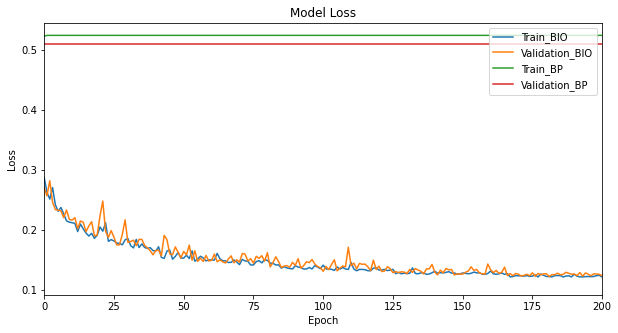

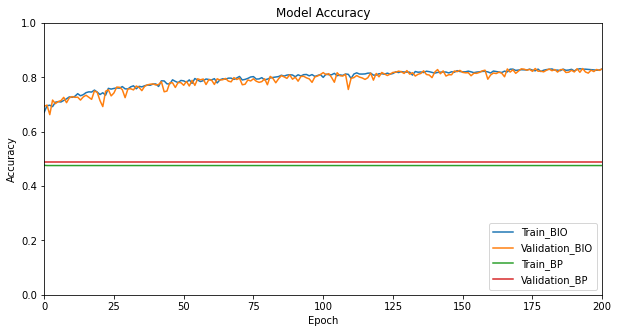

In [209]:
bio_history = bio_logs.history
bp_history = bp_logs.history

plt.figure(figsize=(10, 5))
plt.plot(bio_history['loss'])
plt.plot(bio_history['val_loss'])

plt.plot(bp_history['loss'])
plt.plot(bp_history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(0, 200)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_BP', 'Validation_BP'], loc='upper right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(bio_history['acc'])
plt.plot(bio_history['val_acc'])

plt.plot(bp_history['acc'])
plt.plot(bp_history['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.xlim(0, 200)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_BP', 'Validation_BP'], loc='lower right')
plt.show()

## Plot weights of the BP model

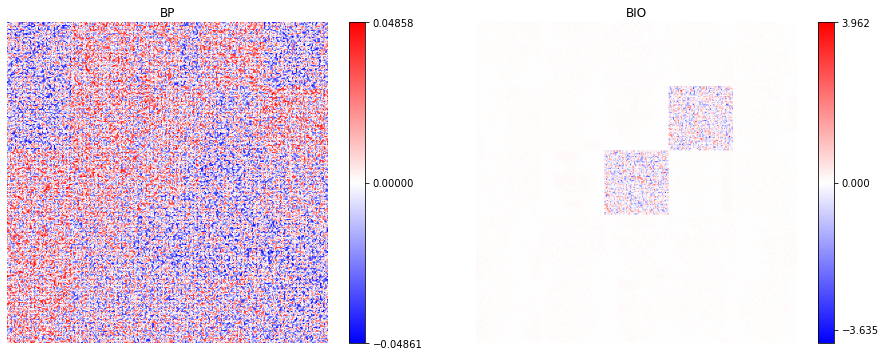

In [211]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].set_title('BP')
ax[1].set_title('BIO')
bp_weights = bp_model.layers[0].get_weights()[0].T
draw_weights(bp_weights, Kx, Ky, -1, ax[0])
draw_weights(synapses, Kx, Ky, -1, ax[1])
plt.tight_layout()
plt.show()

### Control Test: A model with only one output layer
If a model with only one output layer performs on paar with BIO, this means the images themselves are as representative as the biological hidden neurons.

In [212]:
control_model = keras.Sequential([
    layers.Input(shape=(N_in)),
    layers.BatchNormalization(),
    layers.Dense(Nc, activation='softmax')
])
control_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
control_logs = control_model.fit(x_train0, y_train, validation_data=(x_val0, y_val), batch_size=385, epochs=500, verbose=0)

In [213]:
print("Final Training Accuracy:", control_logs.history['acc'][-1])
print("Final Validation Accuracy:", control_logs.history['val_acc'][-1])

Final Training Accuracy: 0.90385145
Final Validation Accuracy: 0.8425926


 ## Define the CNN+BIO model


In [234]:
x_hid_train3 = x_hid_train.reshape(x_hid_train.shape[0], 10, 10, 10)
x_hid_val3 = x_hid_val.reshape(x_hid_val.shape[0], 10, 10, 10)
x_hid_test3 = x_hid_test.reshape(x_hid_test.shape[0], 10, 10, 10)

In [235]:
bio_cnn_model = models.Sequential([
  layers.Conv2D(64, (3,3), activation='relu', input_shape=(10, 10, 10)),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2, activation='sigmoid')
])
bio_cnn_model.summary()

bio_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 8, 8, 64)          5824      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 2, 2, 64)          36928     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_42 (Dense)             (None, 2)               

In [236]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow(
        x_hid_train3, y_train, 
        batch_size=100)
 
validation_generator = train_datagen.flow(
        x_hid_val3, y_val,
        batch_size=10)

D:\Anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (18149, 10, 10, 10) (10 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
D:\Anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2592, 10, 10, 10) (10 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [237]:
bio_cnn_model_history = bio_cnn_model.fit(
      train_generator,
      steps_per_epoch=len(x_hid_val3)/ 100,  
      epochs=1000,
      validation_data=validation_generator,  
      verbose=1)

Epoch 1/1000
17/25 [==================>...........] - ETA: 0s - loss: 0.6926 - acc: 0.5259

D:\Anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
D:\Anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


26/25 [==============================] - 2s 96ms/step - loss: 0.6928 - acc: 0.5200 - val_loss: 0.6930 - val_acc: 0.5100
Epoch 2/1000
26/25 [==============================] - 1s 40ms/step - loss: 0.6925 - acc: 0.5188 - val_loss: 0.6927 - val_acc: 0.5100
Epoch 3/1000
26/25 [==============================] - 1s 39ms/step - loss: 0.6926 - acc: 0.5112 - val_loss: 0.6924 - val_acc: 0.5100
Epoch 4/1000
26/25 [==============================] - 1s 38ms/step - loss: 0.6904 - acc: 0.5375 - val_loss: 0.6930 - val_acc: 0.5100
Epoch 5/1000
26/25 [==============================] - 1s 37ms/step - loss: 0.6899 - acc: 0.5246 - val_loss: 0.6905 - val_acc: 0.5100
Epoch 6/1000
26/25 [==============================] - 1s 39ms/step - loss: 0.6873 - acc: 0.5319 - val_loss: 0.6909 - val_acc: 0.5100
Epoch 7/1000
26/25 [==============================] - 1s 42ms/step - loss: 0.6797 - acc: 0.5375 - val_loss: 0.6738 - val_acc: 0.6395
Epoch 8/1000
26/25 [==============================] - 1s 37ms/step - loss: 0.6652 

26/25 [==============================] - 1s 44ms/step - loss: 0.5721 - acc: 0.7065 - val_loss: 0.5863 - val_acc: 0.6956
Epoch 63/1000
26/25 [==============================] - 1s 45ms/step - loss: 0.5634 - acc: 0.7215 - val_loss: 0.5795 - val_acc: 0.6914
Epoch 64/1000
26/25 [==============================] - 1s 42ms/step - loss: 0.5576 - acc: 0.7185 - val_loss: 0.5968 - val_acc: 0.6927
Epoch 65/1000
26/25 [==============================] - 1s 43ms/step - loss: 0.5605 - acc: 0.7090 - val_loss: 0.5829 - val_acc: 0.6977
Epoch 66/1000
26/25 [==============================] - 1s 39ms/step - loss: 0.5754 - acc: 0.6896 - val_loss: 0.5793 - val_acc: 0.6933
Epoch 67/1000
26/25 [==============================] - 1s 37ms/step - loss: 0.5669 - acc: 0.7081 - val_loss: 0.5834 - val_acc: 0.6908
Epoch 68/1000
26/25 [==============================] - 1s 36ms/step - loss: 0.5706 - acc: 0.7088 - val_loss: 0.5861 - val_acc: 0.6802
Epoch 69/1000
26/25 [==============================] - 1s 36ms/step - loss: 

26/25 [==============================] - 1s 37ms/step - loss: 0.5417 - acc: 0.7188 - val_loss: 0.5707 - val_acc: 0.6910
Epoch 124/1000
26/25 [==============================] - 1s 37ms/step - loss: 0.5399 - acc: 0.7273 - val_loss: 0.5720 - val_acc: 0.6995
Epoch 125/1000
26/25 [==============================] - 1s 37ms/step - loss: 0.5655 - acc: 0.7089 - val_loss: 0.5873 - val_acc: 0.6834
Epoch 126/1000
26/25 [==============================] - 1s 40ms/step - loss: 0.5559 - acc: 0.7187 - val_loss: 0.5754 - val_acc: 0.6981
Epoch 127/1000
26/25 [==============================] - 1s 37ms/step - loss: 0.5549 - acc: 0.7137 - val_loss: 0.5709 - val_acc: 0.6958
Epoch 128/1000
26/25 [==============================] - 1s 36ms/step - loss: 0.5586 - acc: 0.7148 - val_loss: 0.5708 - val_acc: 0.6923
Epoch 129/1000
26/25 [==============================] - 1s 37ms/step - loss: 0.5571 - acc: 0.7148 - val_loss: 0.5692 - val_acc: 0.7031
Epoch 130/1000
26/25 [==============================] - 1s 37ms/step -

Epoch 184/1000
26/25 [==============================] - 1s 36ms/step - loss: 0.5442 - acc: 0.7288 - val_loss: 0.5718 - val_acc: 0.6979
Epoch 185/1000
26/25 [==============================] - 1s 36ms/step - loss: 0.5436 - acc: 0.7309 - val_loss: 0.5721 - val_acc: 0.6958
Epoch 186/1000
26/25 [==============================] - 1s 36ms/step - loss: 0.5489 - acc: 0.7162 - val_loss: 0.5715 - val_acc: 0.7010
Epoch 187/1000
26/25 [==============================] - 1s 36ms/step - loss: 0.5319 - acc: 0.7312 - val_loss: 0.5723 - val_acc: 0.6944
Epoch 188/1000
26/25 [==============================] - 1s 37ms/step - loss: 0.5476 - acc: 0.7237 - val_loss: 0.5641 - val_acc: 0.6997
Epoch 189/1000
26/25 [==============================] - 1s 40ms/step - loss: 0.5360 - acc: 0.7338 - val_loss: 0.5658 - val_acc: 0.6954
Epoch 190/1000
26/25 [==============================] - 1s 37ms/step - loss: 0.5459 - acc: 0.7202 - val_loss: 0.5881 - val_acc: 0.6981
Epoch 191/1000
26/25 [==============================] -

Epoch 245/1000
26/25 [==============================] - 1s 43ms/step - loss: 0.5306 - acc: 0.7329 - val_loss: 0.5591 - val_acc: 0.7120
Epoch 246/1000
26/25 [==============================] - 1s 40ms/step - loss: 0.5155 - acc: 0.7419 - val_loss: 0.5607 - val_acc: 0.7128
Epoch 247/1000
26/25 [==============================] - 1s 40ms/step - loss: 0.5358 - acc: 0.7354 - val_loss: 0.5607 - val_acc: 0.7099
Epoch 248/1000
26/25 [==============================] - 1s 40ms/step - loss: 0.5359 - acc: 0.7221 - val_loss: 0.5636 - val_acc: 0.7087
Epoch 249/1000
26/25 [==============================] - 1s 40ms/step - loss: 0.5173 - acc: 0.7371 - val_loss: 0.5735 - val_acc: 0.6987
Epoch 250/1000
26/25 [==============================] - 1s 40ms/step - loss: 0.5262 - acc: 0.7379 - val_loss: 0.5631 - val_acc: 0.7137
Epoch 251/1000
26/25 [==============================] - 1s 40ms/step - loss: 0.5221 - acc: 0.7489 - val_loss: 0.5643 - val_acc: 0.7114
Epoch 252/1000
26/25 [==============================] -

Epoch 306/1000
26/25 [==============================] - 1s 40ms/step - loss: 0.5058 - acc: 0.7550 - val_loss: 0.5664 - val_acc: 0.7139
Epoch 307/1000
26/25 [==============================] - 1s 40ms/step - loss: 0.5160 - acc: 0.7400 - val_loss: 0.5774 - val_acc: 0.7074
Epoch 308/1000
26/25 [==============================] - 1s 44ms/step - loss: 0.5293 - acc: 0.7417 - val_loss: 0.5822 - val_acc: 0.7054
Epoch 309/1000
26/25 [==============================] - 1s 40ms/step - loss: 0.5194 - acc: 0.7344 - val_loss: 0.5620 - val_acc: 0.7137
Epoch 310/1000
26/25 [==============================] - 1s 40ms/step - loss: 0.5059 - acc: 0.7544 - val_loss: 0.5611 - val_acc: 0.7143
Epoch 311/1000
26/25 [==============================] - 1s 41ms/step - loss: 0.5184 - acc: 0.7398 - val_loss: 0.5642 - val_acc: 0.7184
Epoch 312/1000
26/25 [==============================] - 1s 44ms/step - loss: 0.5157 - acc: 0.7452 - val_loss: 0.5617 - val_acc: 0.7153
Epoch 313/1000
26/25 [==============================] -

Epoch 367/1000
26/25 [==============================] - 1s 40ms/step - loss: 0.4969 - acc: 0.7621 - val_loss: 0.5690 - val_acc: 0.7118
Epoch 368/1000
26/25 [==============================] - 1s 40ms/step - loss: 0.4743 - acc: 0.7713 - val_loss: 0.5651 - val_acc: 0.7184
Epoch 369/1000
26/25 [==============================] - 1s 40ms/step - loss: 0.5006 - acc: 0.7544 - val_loss: 0.5837 - val_acc: 0.7016
Epoch 370/1000
26/25 [==============================] - 1s 40ms/step - loss: 0.5284 - acc: 0.7377 - val_loss: 0.5717 - val_acc: 0.7099
Epoch 371/1000
26/25 [==============================] - 1s 44ms/step - loss: 0.5003 - acc: 0.7498 - val_loss: 0.5763 - val_acc: 0.7047
Epoch 372/1000
26/25 [==============================] - 1s 41ms/step - loss: 0.5041 - acc: 0.7527 - val_loss: 0.5690 - val_acc: 0.7162
Epoch 373/1000
26/25 [==============================] - 1s 40ms/step - loss: 0.5001 - acc: 0.7517 - val_loss: 0.5629 - val_acc: 0.7224
Epoch 374/1000
26/25 [==============================] -

Epoch 428/1000
26/25 [==============================] - 1s 40ms/step - loss: 0.4945 - acc: 0.7579 - val_loss: 0.5685 - val_acc: 0.7089
Epoch 429/1000
26/25 [==============================] - 1s 40ms/step - loss: 0.4901 - acc: 0.7677 - val_loss: 0.5740 - val_acc: 0.7132
Epoch 430/1000
26/25 [==============================] - 1s 41ms/step - loss: 0.4893 - acc: 0.7619 - val_loss: 0.5665 - val_acc: 0.7166
Epoch 431/1000
26/25 [==============================] - 1s 40ms/step - loss: 0.4832 - acc: 0.7619 - val_loss: 0.5673 - val_acc: 0.7149
Epoch 432/1000
26/25 [==============================] - 1s 40ms/step - loss: 0.4883 - acc: 0.7642 - val_loss: 0.5671 - val_acc: 0.7180
Epoch 433/1000
26/25 [==============================] - 1s 40ms/step - loss: 0.5128 - acc: 0.7438 - val_loss: 0.5717 - val_acc: 0.7141
Epoch 434/1000
26/25 [==============================] - 1s 43ms/step - loss: 0.4936 - acc: 0.7592 - val_loss: 0.5710 - val_acc: 0.7159
Epoch 435/1000
26/25 [==============================] -

Epoch 489/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4705 - acc: 0.7727 - val_loss: 0.5866 - val_acc: 0.7060
Epoch 490/1000
26/25 [==============================] - 1s 31ms/step - loss: 0.5046 - acc: 0.7494 - val_loss: 0.5706 - val_acc: 0.7147
Epoch 491/1000
26/25 [==============================] - 1s 28ms/step - loss: 0.4743 - acc: 0.7662 - val_loss: 0.5796 - val_acc: 0.7193
Epoch 492/1000
26/25 [==============================] - 1s 28ms/step - loss: 0.4735 - acc: 0.7800 - val_loss: 0.5772 - val_acc: 0.7170
Epoch 493/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4926 - acc: 0.7662 - val_loss: 0.6223 - val_acc: 0.6912
Epoch 494/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.5058 - acc: 0.7513 - val_loss: 0.5791 - val_acc: 0.7122
Epoch 495/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4755 - acc: 0.7677 - val_loss: 0.6148 - val_acc: 0.6929
Epoch 496/1000
26/25 [==============================] -

Epoch 550/1000
26/25 [==============================] - 1s 30ms/step - loss: 0.4802 - acc: 0.7725 - val_loss: 0.5763 - val_acc: 0.7103
Epoch 551/1000
26/25 [==============================] - 1s 28ms/step - loss: 0.4620 - acc: 0.7721 - val_loss: 0.5812 - val_acc: 0.7141
Epoch 552/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4716 - acc: 0.7719 - val_loss: 0.5742 - val_acc: 0.7168
Epoch 553/1000
26/25 [==============================] - 1s 30ms/step - loss: 0.4728 - acc: 0.7746 - val_loss: 0.5742 - val_acc: 0.7238
Epoch 554/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4631 - acc: 0.7813 - val_loss: 0.5887 - val_acc: 0.7103
Epoch 555/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4738 - acc: 0.7746 - val_loss: 0.5782 - val_acc: 0.7182
Epoch 556/1000
26/25 [==============================] - 1s 28ms/step - loss: 0.4656 - acc: 0.7846 - val_loss: 0.5770 - val_acc: 0.7182
Epoch 557/1000
26/25 [==============================] -

Epoch 611/1000
26/25 [==============================] - 1s 28ms/step - loss: 0.4770 - acc: 0.7770 - val_loss: 0.5873 - val_acc: 0.7043
Epoch 612/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4634 - acc: 0.7827 - val_loss: 0.5854 - val_acc: 0.7087
Epoch 613/1000
26/25 [==============================] - 1s 28ms/step - loss: 0.4745 - acc: 0.7704 - val_loss: 0.5910 - val_acc: 0.7083
Epoch 614/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4646 - acc: 0.7721 - val_loss: 0.5925 - val_acc: 0.7120
Epoch 615/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4621 - acc: 0.7792 - val_loss: 0.5935 - val_acc: 0.7172
Epoch 616/1000
26/25 [==============================] - 1s 33ms/step - loss: 0.4786 - acc: 0.7660 - val_loss: 0.6282 - val_acc: 0.6946
Epoch 617/1000
26/25 [==============================] - 1s 31ms/step - loss: 0.4673 - acc: 0.7719 - val_loss: 0.5882 - val_acc: 0.7114
Epoch 618/1000
26/25 [==============================] -

Epoch 672/1000
26/25 [==============================] - 1s 31ms/step - loss: 0.4616 - acc: 0.7840 - val_loss: 0.5897 - val_acc: 0.7066
Epoch 673/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4500 - acc: 0.7865 - val_loss: 0.5854 - val_acc: 0.7178
Epoch 674/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4467 - acc: 0.7883 - val_loss: 0.6123 - val_acc: 0.7039
Epoch 675/1000
26/25 [==============================] - 1s 28ms/step - loss: 0.4653 - acc: 0.7780 - val_loss: 0.5987 - val_acc: 0.7122
Epoch 676/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4470 - acc: 0.7896 - val_loss: 0.5925 - val_acc: 0.7078
Epoch 677/1000
26/25 [==============================] - 1s 28ms/step - loss: 0.4561 - acc: 0.7752 - val_loss: 0.6100 - val_acc: 0.6968
Epoch 678/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4560 - acc: 0.7808 - val_loss: 0.5844 - val_acc: 0.7095
Epoch 679/1000
26/25 [==============================] -

Epoch 733/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4416 - acc: 0.7912 - val_loss: 0.6387 - val_acc: 0.6929
Epoch 734/1000
26/25 [==============================] - 1s 28ms/step - loss: 0.4495 - acc: 0.7900 - val_loss: 0.5943 - val_acc: 0.7083
Epoch 735/1000
26/25 [==============================] - 1s 30ms/step - loss: 0.4356 - acc: 0.8010 - val_loss: 0.6119 - val_acc: 0.7062
Epoch 736/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4493 - acc: 0.7846 - val_loss: 0.5941 - val_acc: 0.7160
Epoch 737/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4321 - acc: 0.7969 - val_loss: 0.6061 - val_acc: 0.7178
Epoch 738/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4482 - acc: 0.7965 - val_loss: 0.6060 - val_acc: 0.7052
Epoch 739/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4357 - acc: 0.7907 - val_loss: 0.6523 - val_acc: 0.6860
Epoch 740/1000
26/25 [==============================] -

Epoch 794/1000
26/25 [==============================] - 1s 31ms/step - loss: 0.4515 - acc: 0.7835 - val_loss: 0.6008 - val_acc: 0.7004
Epoch 795/1000
26/25 [==============================] - 1s 31ms/step - loss: 0.4252 - acc: 0.8117 - val_loss: 0.6360 - val_acc: 0.6995
Epoch 796/1000
26/25 [==============================] - 1s 31ms/step - loss: 0.4370 - acc: 0.7890 - val_loss: 0.6197 - val_acc: 0.7095
Epoch 797/1000
26/25 [==============================] - 1s 30ms/step - loss: 0.4346 - acc: 0.7975 - val_loss: 0.6015 - val_acc: 0.7164
Epoch 798/1000
26/25 [==============================] - 1s 34ms/step - loss: 0.4364 - acc: 0.7940 - val_loss: 0.6104 - val_acc: 0.7056
Epoch 799/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4189 - acc: 0.8135 - val_loss: 0.6096 - val_acc: 0.7091
Epoch 800/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4299 - acc: 0.8095 - val_loss: 0.6101 - val_acc: 0.7159
Epoch 801/1000
26/25 [==============================] -

Epoch 855/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4324 - acc: 0.7899 - val_loss: 0.6307 - val_acc: 0.7025
Epoch 856/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4272 - acc: 0.8027 - val_loss: 0.6373 - val_acc: 0.6975
Epoch 857/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4192 - acc: 0.8056 - val_loss: 0.6385 - val_acc: 0.7060
Epoch 858/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4094 - acc: 0.8158 - val_loss: 0.6137 - val_acc: 0.7099
Epoch 859/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4173 - acc: 0.8087 - val_loss: 0.6296 - val_acc: 0.7124
Epoch 860/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4307 - acc: 0.8054 - val_loss: 0.6104 - val_acc: 0.7072
Epoch 861/1000
26/25 [==============================] - 1s 35ms/step - loss: 0.3901 - acc: 0.8319 - val_loss: 0.6385 - val_acc: 0.7099
Epoch 862/1000
26/25 [==============================] -

Epoch 916/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.3870 - acc: 0.8269 - val_loss: 0.6362 - val_acc: 0.7114
Epoch 917/1000
26/25 [==============================] - 1s 31ms/step - loss: 0.4230 - acc: 0.8040 - val_loss: 0.6348 - val_acc: 0.7066
Epoch 918/1000
26/25 [==============================] - 1s 30ms/step - loss: 0.3753 - acc: 0.8398 - val_loss: 0.6413 - val_acc: 0.7045
Epoch 919/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.3990 - acc: 0.8176 - val_loss: 0.6335 - val_acc: 0.7006
Epoch 920/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4102 - acc: 0.8044 - val_loss: 0.6712 - val_acc: 0.6962
Epoch 921/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4279 - acc: 0.7992 - val_loss: 0.6216 - val_acc: 0.7083
Epoch 922/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.3877 - acc: 0.8288 - val_loss: 0.6270 - val_acc: 0.7079
Epoch 923/1000
26/25 [==============================] -

Epoch 977/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.4021 - acc: 0.8112 - val_loss: 0.6495 - val_acc: 0.7029
Epoch 978/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.3669 - acc: 0.8437 - val_loss: 0.6422 - val_acc: 0.7087
Epoch 979/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.3815 - acc: 0.8271 - val_loss: 0.6462 - val_acc: 0.7087
Epoch 980/1000
26/25 [==============================] - 1s 31ms/step - loss: 0.4006 - acc: 0.8225 - val_loss: 0.6558 - val_acc: 0.7002
Epoch 981/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.3850 - acc: 0.8221 - val_loss: 0.6603 - val_acc: 0.7008
Epoch 982/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.3924 - acc: 0.8200 - val_loss: 0.6695 - val_acc: 0.7010
Epoch 983/1000
26/25 [==============================] - 1s 29ms/step - loss: 0.3963 - acc: 0.8185 - val_loss: 0.7095 - val_acc: 0.6904
Epoch 984/1000
26/25 [==============================] -

In [238]:
bio_cnn_model.evaluate(x_hid_test3, y_test)

2964/2964 [==============================] - 0s 59us/sample - loss: 642.9867 - acc: 0.5614


[642.9867067736009, 0.5614035]

 ## Define the CNN model

In [227]:
x_train3 = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_val3 = x_val.reshape(x_val.shape[0], 48, 48, 1)
x_test3 = x_test.reshape(x_test.shape[0], 48, 48, 1)

In [228]:
cnn_model = models.Sequential([
  layers.Conv2D(64, (3,3), activation='relu', input_shape=(48, 48, 1)),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2, activation='sigmoid')
])
cnn_model.summary()

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 128)               819328    
_________________________________________________________________
dense_40 (Dense)             (None, 2)               

In [229]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow(
        x_train3, y_train, 
        batch_size=100)
 
validation_generator = train_datagen.flow(
        x_val3, y_val,
        batch_size=10)

In [231]:
cnn_model_history = cnn_model.fit(
      train_generator,
      steps_per_epoch=len(x_val3)/ 100,  
      epochs=1000,
      validation_data=validation_generator,  
      verbose=1)

Epoch 1/1000
26/25 [==============================] - 9s 338ms/step - loss: 0.2549 - acc: 0.8988 - val_loss: 0.2822 - val_acc: 0.8773
Epoch 2/1000
26/25 [==============================] - 9s 343ms/step - loss: 0.2399 - acc: 0.9013 - val_loss: 0.2831 - val_acc: 0.8829
Epoch 3/1000
26/25 [==============================] - 9s 349ms/step - loss: 0.2511 - acc: 0.8860 - val_loss: 0.2768 - val_acc: 0.8860
Epoch 4/1000
26/25 [==============================] - 9s 328ms/step - loss: 0.2469 - acc: 0.8944 - val_loss: 0.2761 - val_acc: 0.8858
Epoch 5/1000
26/25 [==============================] - 8s 308ms/step - loss: 0.2438 - acc: 0.8956 - val_loss: 0.2763 - val_acc: 0.8819
Epoch 6/1000
26/25 [==============================] - 8s 303ms/step - loss: 0.2492 - acc: 0.8933 - val_loss: 0.2841 - val_acc: 0.8708
Epoch 7/1000
26/25 [==============================] - 8s 307ms/step - loss: 0.2441 - acc: 0.9017 - val_loss: 0.2885 - val_acc: 0.8661
Epoch 8/1000
26/25 [==============================] - 8s 306ms

Epoch 62/1000
26/25 [==============================] - 8s 302ms/step - loss: 0.2260 - acc: 0.9050 - val_loss: 0.2797 - val_acc: 0.8833
Epoch 63/1000
26/25 [==============================] - 9s 340ms/step - loss: 0.2163 - acc: 0.9060 - val_loss: 0.2808 - val_acc: 0.8736
Epoch 64/1000
26/25 [==============================] - 8s 326ms/step - loss: 0.2126 - acc: 0.9094 - val_loss: 0.2843 - val_acc: 0.8791
Epoch 65/1000
26/25 [==============================] - 8s 312ms/step - loss: 0.2214 - acc: 0.9044 - val_loss: 0.2854 - val_acc: 0.8758
Epoch 66/1000
26/25 [==============================] - 8s 321ms/step - loss: 0.2055 - acc: 0.9183 - val_loss: 0.2780 - val_acc: 0.8789
Epoch 67/1000
26/25 [==============================] - 9s 333ms/step - loss: 0.2348 - acc: 0.8942 - val_loss: 0.2789 - val_acc: 0.8800
Epoch 68/1000
26/25 [==============================] - 9s 334ms/step - loss: 0.2090 - acc: 0.9183 - val_loss: 0.2792 - val_acc: 0.8781
Epoch 69/1000
26/25 [==============================] - 

26/25 [==============================] - 8s 298ms/step - loss: 0.1834 - acc: 0.9296 - val_loss: 0.2890 - val_acc: 0.8812
Epoch 123/1000
26/25 [==============================] - 8s 302ms/step - loss: 0.2007 - acc: 0.9235 - val_loss: 0.2757 - val_acc: 0.8850
Epoch 124/1000
26/25 [==============================] - 8s 304ms/step - loss: 0.1892 - acc: 0.9244 - val_loss: 0.2783 - val_acc: 0.8825
Epoch 125/1000
26/25 [==============================] - 9s 341ms/step - loss: 0.2004 - acc: 0.9148 - val_loss: 0.2801 - val_acc: 0.8821
Epoch 126/1000
26/25 [==============================] - 8s 319ms/step - loss: 0.2037 - acc: 0.9162 - val_loss: 0.2845 - val_acc: 0.8818
Epoch 127/1000
26/25 [==============================] - 9s 342ms/step - loss: 0.1918 - acc: 0.9231 - val_loss: 0.2776 - val_acc: 0.8870
Epoch 128/1000
26/25 [==============================] - 8s 321ms/step - loss: 0.1840 - acc: 0.9225 - val_loss: 0.2953 - val_acc: 0.8777
Epoch 129/1000
26/25 [==============================] - 8s 321m

26/25 [==============================] - 8s 292ms/step - loss: 0.1596 - acc: 0.9349 - val_loss: 0.2995 - val_acc: 0.8804
Epoch 183/1000
26/25 [==============================] - 8s 305ms/step - loss: 0.1554 - acc: 0.9392 - val_loss: 0.2969 - val_acc: 0.8792
Epoch 184/1000
26/25 [==============================] - 8s 299ms/step - loss: 0.1626 - acc: 0.9348 - val_loss: 0.3087 - val_acc: 0.8713
Epoch 185/1000
26/25 [==============================] - 9s 331ms/step - loss: 0.1662 - acc: 0.9383 - val_loss: 0.2889 - val_acc: 0.8835
Epoch 186/1000
26/25 [==============================] - 8s 311ms/step - loss: 0.1793 - acc: 0.9294 - val_loss: 0.2932 - val_acc: 0.8789
Epoch 187/1000
26/25 [==============================] - 8s 321ms/step - loss: 0.1656 - acc: 0.9410 - val_loss: 0.2869 - val_acc: 0.8854
Epoch 188/1000
26/25 [==============================] - 8s 312ms/step - loss: 0.1650 - acc: 0.9377 - val_loss: 0.3051 - val_acc: 0.8746
Epoch 189/1000
26/25 [==============================] - 9s 330m

26/25 [==============================] - 8s 300ms/step - loss: 0.1407 - acc: 0.9435 - val_loss: 0.3124 - val_acc: 0.8810
Epoch 243/1000
26/25 [==============================] - 8s 301ms/step - loss: 0.1493 - acc: 0.9400 - val_loss: 0.3250 - val_acc: 0.8802
Epoch 244/1000
26/25 [==============================] - 8s 302ms/step - loss: 0.1505 - acc: 0.9423 - val_loss: 0.3168 - val_acc: 0.8835
Epoch 245/1000
26/25 [==============================] - 8s 308ms/step - loss: 0.1395 - acc: 0.9531 - val_loss: 0.3166 - val_acc: 0.8731
Epoch 246/1000
26/25 [==============================] - 8s 309ms/step - loss: 0.1288 - acc: 0.9550 - val_loss: 0.2980 - val_acc: 0.8864
Epoch 247/1000
26/25 [==============================] - 8s 304ms/step - loss: 0.1284 - acc: 0.9473 - val_loss: 0.3096 - val_acc: 0.8848
Epoch 248/1000
26/25 [==============================] - 8s 307ms/step - loss: 0.1414 - acc: 0.9479 - val_loss: 0.3087 - val_acc: 0.88413s - loss: 0.1
Epoch 249/1000
26/25 [===========================

26/25 [==============================] - 9s 328ms/step - loss: 0.1170 - acc: 0.9608 - val_loss: 0.3365 - val_acc: 0.8802
Epoch 303/1000
26/25 [==============================] - 8s 322ms/step - loss: 0.1214 - acc: 0.9563 - val_loss: 0.3284 - val_acc: 0.8819
Epoch 304/1000
26/25 [==============================] - 8s 324ms/step - loss: 0.1062 - acc: 0.9623 - val_loss: 0.3349 - val_acc: 0.8845
Epoch 305/1000
26/25 [==============================] - 8s 325ms/step - loss: 0.1054 - acc: 0.9615 - val_loss: 0.3405 - val_acc: 0.8829
Epoch 306/1000
26/25 [==============================] - 8s 307ms/step - loss: 0.1126 - acc: 0.9579 - val_loss: 0.3340 - val_acc: 0.8808
Epoch 307/1000
26/25 [==============================] - 8s 301ms/step - loss: 0.1194 - acc: 0.9565 - val_loss: 0.3775 - val_acc: 0.8684
Epoch 308/1000
26/25 [==============================] - 8s 298ms/step - loss: 0.1226 - acc: 0.9514 - val_loss: 0.3436 - val_acc: 0.8808
Epoch 309/1000
26/25 [==============================] - 8s 301m

26/25 [==============================] - 9s 334ms/step - loss: 0.1274 - acc: 0.9440 - val_loss: 0.3870 - val_acc: 0.8711
Epoch 363/1000
26/25 [==============================] - 9s 344ms/step - loss: 0.1303 - acc: 0.9492 - val_loss: 0.3684 - val_acc: 0.8727
Epoch 364/1000
26/25 [==============================] - 9s 329ms/step - loss: 0.1080 - acc: 0.9602 - val_loss: 0.3598 - val_acc: 0.8785
Epoch 365/1000
26/25 [==============================] - 8s 297ms/step - loss: 0.0938 - acc: 0.9676 - val_loss: 0.3620 - val_acc: 0.8773
Epoch 366/1000
26/25 [==============================] - 8s 298ms/step - loss: 0.0947 - acc: 0.9669 - val_loss: 0.3617 - val_acc: 0.8781
Epoch 367/1000
26/25 [==============================] - 8s 304ms/step - loss: 0.0887 - acc: 0.9704 - val_loss: 0.3625 - val_acc: 0.8773
Epoch 368/1000
26/25 [==============================] - 8s 306ms/step - loss: 0.0978 - acc: 0.9644 - val_loss: 0.3709 - val_acc: 0.8771
Epoch 369/1000
26/25 [==============================] - 8s 302m

26/25 [==============================] - 8s 313ms/step - loss: 0.0754 - acc: 0.9763 - val_loss: 0.4162 - val_acc: 0.8781
Epoch 423/1000
26/25 [==============================] - 8s 324ms/step - loss: 0.0817 - acc: 0.9737 - val_loss: 0.3933 - val_acc: 0.8767
Epoch 424/1000
26/25 [==============================] - 8s 313ms/step - loss: 0.0712 - acc: 0.9773 - val_loss: 0.4111 - val_acc: 0.8717
Epoch 425/1000
26/25 [==============================] - 8s 320ms/step - loss: 0.0691 - acc: 0.9745 - val_loss: 0.4087 - val_acc: 0.8765
Epoch 426/1000
26/25 [==============================] - 8s 321ms/step - loss: 0.0793 - acc: 0.9706 - val_loss: 0.4041 - val_acc: 0.8779
Epoch 427/1000
26/25 [==============================] - 8s 315ms/step - loss: 0.0754 - acc: 0.9735 - val_loss: 0.4112 - val_acc: 0.8717
Epoch 428/1000
26/25 [==============================] - 8s 319ms/step - loss: 0.0763 - acc: 0.9737 - val_loss: 0.4080 - val_acc: 0.8779
Epoch 429/1000
26/25 [==============================] - 8s 315m

26/25 [==============================] - 8s 300ms/step - loss: 0.0540 - acc: 0.9835 - val_loss: 0.4516 - val_acc: 0.8735
Epoch 483/1000
26/25 [==============================] - 8s 300ms/step - loss: 0.0550 - acc: 0.9838 - val_loss: 0.4523 - val_acc: 0.8750
Epoch 484/1000
26/25 [==============================] - 8s 300ms/step - loss: 0.0531 - acc: 0.9829 - val_loss: 0.4563 - val_acc: 0.8725
Epoch 485/1000
26/25 [==============================] - 8s 304ms/step - loss: 0.0552 - acc: 0.9817 - val_loss: 0.4585 - val_acc: 0.8725
Epoch 486/1000
26/25 [==============================] - 8s 303ms/step - loss: 0.0556 - acc: 0.9838 - val_loss: 0.4415 - val_acc: 0.8754
Epoch 487/1000
26/25 [==============================] - 8s 300ms/step - loss: 0.0451 - acc: 0.9856 - val_loss: 0.4615 - val_acc: 0.8762
Epoch 488/1000
26/25 [==============================] - 8s 298ms/step - loss: 0.0552 - acc: 0.9823 - val_loss: 0.4462 - val_acc: 0.8736
Epoch 489/1000
26/25 [==============================] - 8s 300m

26/25 [==============================] - 8s 309ms/step - loss: 0.0496 - acc: 0.9835 - val_loss: 0.5189 - val_acc: 0.8711
Epoch 543/1000
26/25 [==============================] - 8s 315ms/step - loss: 0.0459 - acc: 0.9850 - val_loss: 0.5096 - val_acc: 0.8708
Epoch 544/1000
26/25 [==============================] - 9s 333ms/step - loss: 0.0492 - acc: 0.9831 - val_loss: 0.5102 - val_acc: 0.8704
Epoch 545/1000
26/25 [==============================] - 8s 316ms/step - loss: 0.0462 - acc: 0.9848 - val_loss: 0.5133 - val_acc: 0.8719
Epoch 546/1000
26/25 [==============================] - 8s 317ms/step - loss: 0.0420 - acc: 0.9869 - val_loss: 0.5283 - val_acc: 0.8700
Epoch 547/1000
26/25 [==============================] - 8s 314ms/step - loss: 0.0344 - acc: 0.9908 - val_loss: 0.5258 - val_acc: 0.8742
Epoch 548/1000
26/25 [==============================] - 8s 311ms/step - loss: 0.0388 - acc: 0.9894 - val_loss: 0.5385 - val_acc: 0.8719
Epoch 549/1000
26/25 [==============================] - 8s 310m

26/25 [==============================] - 8s 312ms/step - loss: 0.0429 - acc: 0.9877 - val_loss: 0.5693 - val_acc: 0.8713
Epoch 603/1000
26/25 [==============================] - 8s 299ms/step - loss: 0.0302 - acc: 0.9927 - val_loss: 0.5569 - val_acc: 0.8723
Epoch 604/1000
26/25 [==============================] - 8s 305ms/step - loss: 0.0346 - acc: 0.9881 - val_loss: 0.5916 - val_acc: 0.8727
Epoch 605/1000
26/25 [==============================] - 8s 306ms/step - loss: 0.0287 - acc: 0.9912 - val_loss: 0.5651 - val_acc: 0.8746
Epoch 606/1000
26/25 [==============================] - 8s 301ms/step - loss: 0.0321 - acc: 0.9898 - val_loss: 0.5702 - val_acc: 0.8704
Epoch 607/1000
26/25 [==============================] - 8s 297ms/step - loss: 0.0276 - acc: 0.9925 - val_loss: 0.5722 - val_acc: 0.8723
Epoch 608/1000
26/25 [==============================] - 8s 297ms/step - loss: 0.0492 - acc: 0.9796 - val_loss: 0.5900 - val_acc: 0.8675
Epoch 609/1000
26/25 [==============================] - 8s 300m

26/25 [==============================] - 8s 303ms/step - loss: 0.0288 - acc: 0.9913 - val_loss: 0.6292 - val_acc: 0.8688
Epoch 663/1000
26/25 [==============================] - 8s 307ms/step - loss: 0.0265 - acc: 0.9931 - val_loss: 0.6251 - val_acc: 0.8748
Epoch 664/1000
26/25 [==============================] - 8s 305ms/step - loss: 0.0285 - acc: 0.9915 - val_loss: 0.6148 - val_acc: 0.8754
Epoch 665/1000
26/25 [==============================] - 8s 300ms/step - loss: 0.0272 - acc: 0.9931 - val_loss: 0.6152 - val_acc: 0.8696
Epoch 666/1000
26/25 [==============================] - 8s 305ms/step - loss: 0.0237 - acc: 0.9935 - val_loss: 0.6369 - val_acc: 0.8709
Epoch 667/1000
26/25 [==============================] - 8s 307ms/step - loss: 0.0302 - acc: 0.9896 - val_loss: 0.6412 - val_acc: 0.8738
Epoch 668/1000
26/25 [==============================] - 8s 297ms/step - loss: 0.0338 - acc: 0.9898 - val_loss: 0.6529 - val_acc: 0.8661
Epoch 669/1000
26/25 [==============================] - 8s 304m

26/25 [==============================] - 8s 305ms/step - loss: 0.0251 - acc: 0.9929 - val_loss: 0.6600 - val_acc: 0.8727
Epoch 723/1000
26/25 [==============================] - 8s 299ms/step - loss: 0.0156 - acc: 0.9973 - val_loss: 0.6561 - val_acc: 0.8762
Epoch 724/1000
26/25 [==============================] - 8s 299ms/step - loss: 0.0197 - acc: 0.9954 - val_loss: 0.6504 - val_acc: 0.8717
Epoch 725/1000
26/25 [==============================] - 8s 298ms/step - loss: 0.0238 - acc: 0.9931 - val_loss: 0.6594 - val_acc: 0.8781
Epoch 726/1000
26/25 [==============================] - 8s 302ms/step - loss: 0.0229 - acc: 0.9954 - val_loss: 0.6647 - val_acc: 0.8715
Epoch 727/1000
26/25 [==============================] - 8s 303ms/step - loss: 0.0232 - acc: 0.9935 - val_loss: 0.6722 - val_acc: 0.8723
Epoch 728/1000
26/25 [==============================] - 8s 303ms/step - loss: 0.0280 - acc: 0.9919 - val_loss: 0.6710 - val_acc: 0.8750
Epoch 729/1000
26/25 [==============================] - 8s 322m

26/25 [==============================] - 8s 301ms/step - loss: 0.0235 - acc: 0.9927 - val_loss: 0.7096 - val_acc: 0.8742
Epoch 783/1000
26/25 [==============================] - 8s 298ms/step - loss: 0.0272 - acc: 0.9910 - val_loss: 0.7209 - val_acc: 0.8700
Epoch 784/1000
26/25 [==============================] - 8s 302ms/step - loss: 0.0252 - acc: 0.9917 - val_loss: 0.7520 - val_acc: 0.8746
Epoch 785/1000
26/25 [==============================] - 8s 297ms/step - loss: 0.0311 - acc: 0.9923 - val_loss: 0.7365 - val_acc: 0.8671
Epoch 786/1000
26/25 [==============================] - 8s 299ms/step - loss: 0.0361 - acc: 0.9848 - val_loss: 0.7115 - val_acc: 0.8704
Epoch 787/1000
26/25 [==============================] - 8s 299ms/step - loss: 0.0250 - acc: 0.9933 - val_loss: 0.7267 - val_acc: 0.8762
Epoch 788/1000
26/25 [==============================] - 8s 302ms/step - loss: 0.0280 - acc: 0.9919 - val_loss: 0.7029 - val_acc: 0.8762
Epoch 789/1000
26/25 [==============================] - 8s 309m

26/25 [==============================] - 8s 303ms/step - loss: 0.0436 - acc: 0.9846 - val_loss: 0.8092 - val_acc: 0.8632
Epoch 843/1000
26/25 [==============================] - 8s 308ms/step - loss: 0.0450 - acc: 0.9854 - val_loss: 0.7723 - val_acc: 0.8719
Epoch 844/1000
26/25 [==============================] - 8s 306ms/step - loss: 0.0547 - acc: 0.9808 - val_loss: 0.7620 - val_acc: 0.8684
Epoch 845/1000
26/25 [==============================] - 8s 300ms/step - loss: 0.0466 - acc: 0.9827 - val_loss: 0.7784 - val_acc: 0.8688
Epoch 846/1000
26/25 [==============================] - 8s 298ms/step - loss: 0.0345 - acc: 0.9862 - val_loss: 0.7763 - val_acc: 0.8673
Epoch 847/1000
26/25 [==============================] - 8s 313ms/step - loss: 0.0334 - acc: 0.9887 - val_loss: 0.8091 - val_acc: 0.8723
Epoch 848/1000
26/25 [==============================] - 8s 300ms/step - loss: 0.0311 - acc: 0.9896 - val_loss: 0.7627 - val_acc: 0.8665
Epoch 849/1000
26/25 [==============================] - 8s 299m

26/25 [==============================] - 8s 313ms/step - loss: 0.0178 - acc: 0.9942 - val_loss: 0.8073 - val_acc: 0.8704
Epoch 903/1000
26/25 [==============================] - 8s 315ms/step - loss: 0.0191 - acc: 0.9950 - val_loss: 0.7735 - val_acc: 0.8765
Epoch 904/1000
26/25 [==============================] - 8s 299ms/step - loss: 0.0188 - acc: 0.9958 - val_loss: 0.7652 - val_acc: 0.8750
Epoch 905/1000
26/25 [==============================] - 8s 307ms/step - loss: 0.0117 - acc: 0.9981 - val_loss: 0.7770 - val_acc: 0.8731
Epoch 906/1000
26/25 [==============================] - 8s 308ms/step - loss: 0.0132 - acc: 0.9981 - val_loss: 0.7851 - val_acc: 0.8765
Epoch 907/1000
26/25 [==============================] - 8s 316ms/step - loss: 0.0152 - acc: 0.9969 - val_loss: 0.7869 - val_acc: 0.8704
Epoch 908/1000
26/25 [==============================] - 8s 320ms/step - loss: 0.0136 - acc: 0.9973 - val_loss: 0.7793 - val_acc: 0.8785
Epoch 909/1000
26/25 [==============================] - 9s 335m

26/25 [==============================] - 8s 294ms/step - loss: 0.0160 - acc: 0.9961 - val_loss: 0.8126 - val_acc: 0.8744
Epoch 963/1000
26/25 [==============================] - 8s 304ms/step - loss: 0.0120 - acc: 0.9969 - val_loss: 0.8106 - val_acc: 0.8715
Epoch 964/1000
26/25 [==============================] - 8s 306ms/step - loss: 0.0167 - acc: 0.9958 - val_loss: 0.8317 - val_acc: 0.8700
Epoch 965/1000
26/25 [==============================] - 8s 298ms/step - loss: 0.0179 - acc: 0.9946 - val_loss: 0.8560 - val_acc: 0.8750
Epoch 966/1000
26/25 [==============================] - 8s 301ms/step - loss: 0.0177 - acc: 0.9942 - val_loss: 0.8827 - val_acc: 0.8673
Epoch 967/1000
26/25 [==============================] - 8s 299ms/step - loss: 0.0162 - acc: 0.9946 - val_loss: 0.8612 - val_acc: 0.8758
Epoch 968/1000
26/25 [==============================] - 8s 294ms/step - loss: 0.0138 - acc: 0.9965 - val_loss: 0.8409 - val_acc: 0.8727
Epoch 969/1000
26/25 [==============================] - 8s 299m

In [232]:
cnn_model.evaluate(x_test3, y_test)

2964/2964 [==============================] - 2s 651us/sample - loss: 285.4432 - acc: 0.6522


[285.44319284621844, 0.6521593]

## Plot losses and accuracies

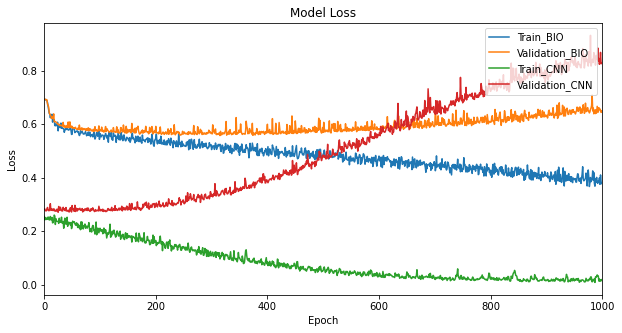

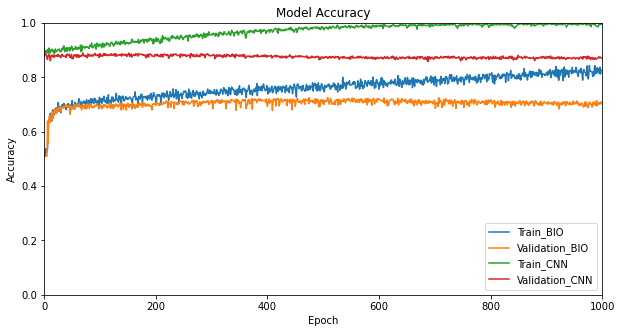

In [240]:
bio_cnn_model_history_plot = bio_cnn_model_history.history
cnn_model_history_plot = cnn_model_history.history

plt.figure(figsize=(10, 5))
plt.plot(bio_cnn_model_history_plot['loss'])
plt.plot(bio_cnn_model_history_plot['val_loss'])

plt.plot(cnn_model_history_plot['loss'])
plt.plot(cnn_model_history_plot['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.ylim(0, 1)
plt.xlim(0, 1000)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_CNN', 'Validation_CNN'], loc='upper right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(bio_cnn_model_history_plot['acc'])
plt.plot(bio_cnn_model_history_plot['val_acc'])

plt.plot(cnn_model_history_plot['acc'])
plt.plot(cnn_model_history_plot['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.xlim(0, 1000)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_CNN', 'Validation_CNN'], loc='lower right')
plt.show()

## This code illustrates the fast AI implementation of the unsupervised "biological" learning algorithm from [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116) on faces data set (ethnicity classification). 

## Imports and Parameters

In [92]:
eps0 = 4e-2    # initial learning rate for the unsupervised part
Kx = 5
Ky = 5
hid_disp = Kx*Ky    # number of hidden units that are displayed in Ky by Kx array
N_hid = 1000    # number of hidden units
mu = 0.0
sigma = 1.0
Nep = 2000     # number of epochs
N_batch = 100  # size of the minibatch
prec = 1e-30
delta = 0.4    # Strength of the anti-hebbian learning
p = 2        # Lebesgue norm of the weights
k = 2          # ranking parameter, must be integer that is bigger or equal than 2

N_in = 2304     # input units
Nc = 5        # number of classes
val_split = 0.2

## Data
Let's load dataset (the same that was used for gender classification):
- Shuffle them
- Normalize to \[0, 1\] range
- Reshape images to (#samples, 1024) and labels to (#samples, 5)
- Split the train part to 18149 train and 2964 validation samples

In [93]:
X = img_data
y = np.array(data_csv["ethnicity"].astype('category'))
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=val_split, random_state=42)

# shuffle
x_train, y_train, x_test, y_test = shuffle(x_train, y_train, x_test, y_test)

# normalize
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# indices of validation splilt
val_idx = np.random.choice(x_train.shape[0], int(val_split * x_train.shape[0]), replace=False)

#split validation
x_val = x_train[val_idx]
y_val = y_train[val_idx]
x_train = np.delete(x_train, val_idx, axis=0)
y_train = np.delete(y_train, val_idx, axis=0)

# some logging
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, Nc)
y_val = keras.utils.to_categorical(y_val, Nc)
y_test = keras.utils.to_categorical(y_test, Nc)

x_train shape: (15172, 2304)
y_train shape: (15172,)
x_val shape: (3792, 2304)
y_val shape: (3792,)
15172 train samples
4741 test samples


## Saving or loading synapses
- If you want to train your own synapses, use the previous method for gender training insupervised bio-model
- If you want to load a pre-trained model, use the `np.load` function in the second line

A sample `synapses.npy` file can be found [here](https://drive.google.com/file/d/1ZEHI4yCa8ZqrwySM5_3jy-bcIenlUuA4/view?usp=sharing)


In [95]:
# load a pre-trained model
synapses = np.load('FaceEthnicity_synapses_hid1000_epoch100_eps4e-2_p2.5_k2_batch100_delta0.5.npy')

<IPython.core.display.Javascript object>


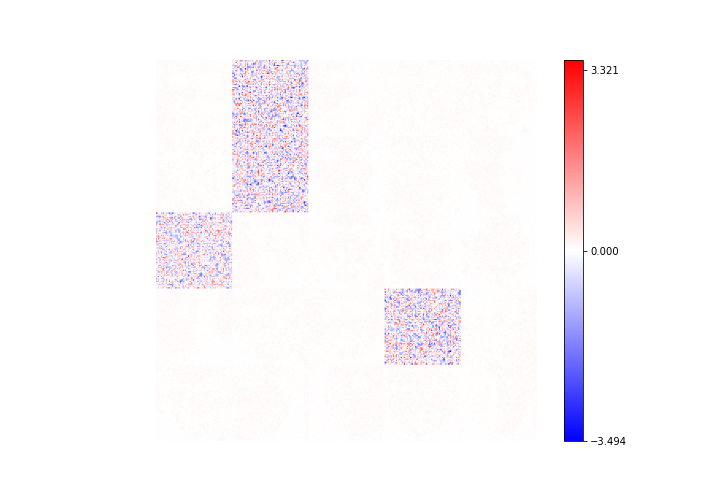

In [96]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(10, 7))
draw_weights(synapses, Kx, Ky)

In [121]:
synapses.min()
syn_list = synapses.ravel()
syn_count = np.prod(synapses.shape)
print('Number of weights:', syn_count)
nonzero_count = np.count_nonzero(synapses)
print('Number of zero weights:', syn_count-nonzero_count)
nonzero_proportion = nonzero_count/syn_count
print('Proportion of zero weights', nonzero_proportion.round(2))
negative_count = np.count_nonzero(synapses<0)
print('Negative weights count:', negative_count)
positive_count = np.count_nonzero(synapses>0)
print('Positive weights count:', positive_count)

Number of weights: 2304000
Number of zero weights: 0
Proportion of zero weights 1.0
Negative weights count: 312154
Positive weights count: 1991846


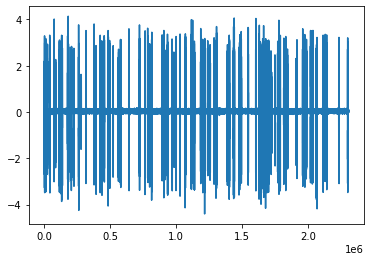

In [122]:
%matplotlib inline
plt.plot(syn_list)
plt.show()

## Testing: compute hidden neurons for train, val, and test data
This will be the input to the second layer, which will be trained to do ethnitical recognition.

In [97]:
# Center and normalize input data to unit vectors  
x_train0 = normalize(x_train)
x_val0 = normalize(x_val)
x_test0 = normalize(x_test)

x_hid_train = forward(x_train0, synapses, p, N_hid, N_train, training=False)
x_hid_val = forward(x_val0, synapses, p, N_hid, N_val, training=False)
x_hid_test = forward(x_test0, synapses, p, N_hid, N_val, training=False)

n=2
x_hid_train = (x_hid_train * (x_hid_train>0)) ** n
x_hid_val = (x_hid_val * (x_hid_val>0)) ** n

## Define the BIO model
- Input is the pre-computed hidden activations.
- Output layer is a fully connected layer with softmax activation
- Loss function is the categorical cross-entropy
- Optimizer is Adam with initial learning rate of 0.1 which decays exponentially every 20 epochs with a decay rate of 0.7
- Batch size is 100 and number of epochs is 100

Set `verbose=1` in the `model.fit()` function to see the loss and accuracy values after each epoch.

In [98]:
bio_model = keras.Sequential([
    layers.Input(shape=(N_hid,)),
    layers.Dense(Nc),
    layers.Activation('softmax')
])
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-1, decay_steps=Nep*20, decay_rate=0.7, staircase=True)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
bio_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
bio_logs = bio_model.fit(x_hid_train, y_train, validation_data=(x_hid_val, y_val), batch_size=385, epochs=500, verbose=1)

Train on 15172 samples, validate on 3792 samples
Epoch 1/500
15172/15172 [==============================] - 1s 82us/sample - loss: 0.2148 - acc: 0.4251 - val_loss: 0.2155 - val_acc: 0.4314
Epoch 2/500
15172/15172 [==============================] - 1s 48us/sample - loss: 0.2008 - acc: 0.4543 - val_loss: 0.2026 - val_acc: 0.4541
Epoch 3/500
15172/15172 [==============================] - 1s 45us/sample - loss: 0.1815 - acc: 0.4918 - val_loss: 0.1793 - val_acc: 0.4897
Epoch 4/500
15172/15172 [==============================] - 1s 55us/sample - loss: 0.1810 - acc: 0.5059 - val_loss: 0.1940 - val_acc: 0.4897
Epoch 5/500
15172/15172 [==============================] - 1s 59us/sample - loss: 0.1772 - acc: 0.5210 - val_loss: 0.1810 - val_acc: 0.4950
Epoch 6/500
15172/15172 [==============================] - 1s 52us/sample - loss: 0.1640 - acc: 0.5442 - val_loss: 0.1725 - val_acc: 0.5245
Epoch 7/500
15172/15172 [==============================] - 1s 51us/sample - loss: 0.1585 - acc: 0.5522 - val_lo

Epoch 59/500
15172/15172 [==============================] - 1s 45us/sample - loss: 0.1111 - acc: 0.6590 - val_loss: 0.1214 - val_acc: 0.6300
Epoch 60/500
15172/15172 [==============================] - 1s 42us/sample - loss: 0.1075 - acc: 0.6689 - val_loss: 0.1192 - val_acc: 0.6303
Epoch 61/500
15172/15172 [==============================] - 1s 47us/sample - loss: 0.1026 - acc: 0.6802 - val_loss: 0.1143 - val_acc: 0.6482
Epoch 62/500
15172/15172 [==============================] - 1s 50us/sample - loss: 0.1052 - acc: 0.6719 - val_loss: 0.1293 - val_acc: 0.6158
Epoch 63/500
15172/15172 [==============================] - 1s 42us/sample - loss: 0.1116 - acc: 0.6583 - val_loss: 0.1143 - val_acc: 0.6461
Epoch 64/500
15172/15172 [==============================] - 1s 48us/sample - loss: 0.1051 - acc: 0.6745 - val_loss: 0.1132 - val_acc: 0.6400
Epoch 65/500
15172/15172 [==============================] - 1s 50us/sample - loss: 0.1084 - acc: 0.6657 - val_loss: 0.1269 - val_acc: 0.6026
Epoch 66/500


Epoch 117/500
15172/15172 [==============================] - 1s 50us/sample - loss: 0.0974 - acc: 0.6973 - val_loss: 0.1127 - val_acc: 0.6445
Epoch 118/500
15172/15172 [==============================] - 1s 48us/sample - loss: 0.0957 - acc: 0.7006 - val_loss: 0.1053 - val_acc: 0.6685
Epoch 119/500
15172/15172 [==============================] - 1s 42us/sample - loss: 0.1005 - acc: 0.6871 - val_loss: 0.1186 - val_acc: 0.6395
Epoch 120/500
15172/15172 [==============================] - 1s 40us/sample - loss: 0.1000 - acc: 0.6931 - val_loss: 0.1172 - val_acc: 0.6355
Epoch 121/500
15172/15172 [==============================] - 1s 45us/sample - loss: 0.1018 - acc: 0.6859 - val_loss: 0.1148 - val_acc: 0.6440
Epoch 122/500
15172/15172 [==============================] - 1s 54us/sample - loss: 0.0977 - acc: 0.6982 - val_loss: 0.1150 - val_acc: 0.6493
Epoch 123/500
15172/15172 [==============================] - 1s 38us/sample - loss: 0.0996 - acc: 0.6927 - val_loss: 0.1069 - val_acc: 0.6632
Epoch 

Epoch 175/500
15172/15172 [==============================] - 1s 50us/sample - loss: 0.0951 - acc: 0.7085 - val_loss: 0.1099 - val_acc: 0.6630
Epoch 176/500
15172/15172 [==============================] - 1s 42us/sample - loss: 0.0950 - acc: 0.7092 - val_loss: 0.1056 - val_acc: 0.6770
Epoch 177/500
15172/15172 [==============================] - 1s 47us/sample - loss: 0.0932 - acc: 0.7133 - val_loss: 0.1086 - val_acc: 0.6640
Epoch 178/500
15172/15172 [==============================] - 1s 48us/sample - loss: 0.0927 - acc: 0.7161 - val_loss: 0.1065 - val_acc: 0.6680
Epoch 179/500
15172/15172 [==============================] - 1s 46us/sample - loss: 0.0938 - acc: 0.7110 - val_loss: 0.1108 - val_acc: 0.6627
Epoch 180/500
15172/15172 [==============================] - 1s 45us/sample - loss: 0.1000 - acc: 0.6945 - val_loss: 0.1130 - val_acc: 0.6524
Epoch 181/500
15172/15172 [==============================] - 1s 46us/sample - loss: 0.0962 - acc: 0.7058 - val_loss: 0.1076 - val_acc: 0.6667
Epoch 

Epoch 233/500
15172/15172 [==============================] - 1s 42us/sample - loss: 0.0954 - acc: 0.7102 - val_loss: 0.1125 - val_acc: 0.6617
Epoch 234/500
15172/15172 [==============================] - 1s 48us/sample - loss: 0.0908 - acc: 0.7219 - val_loss: 0.1098 - val_acc: 0.6638
Epoch 235/500
15172/15172 [==============================] - 1s 46us/sample - loss: 0.0929 - acc: 0.7173 - val_loss: 0.1168 - val_acc: 0.6548
Epoch 236/500
15172/15172 [==============================] - 1s 42us/sample - loss: 0.0930 - acc: 0.7164 - val_loss: 0.1080 - val_acc: 0.6659
Epoch 237/500
15172/15172 [==============================] - 1s 41us/sample - loss: 0.0961 - acc: 0.7076 - val_loss: 0.1141 - val_acc: 0.6627
Epoch 238/500
15172/15172 [==============================] - 1s 44us/sample - loss: 0.0973 - acc: 0.7075 - val_loss: 0.1107 - val_acc: 0.6635
Epoch 239/500
15172/15172 [==============================] - 1s 55us/sample - loss: 0.0974 - acc: 0.7071 - val_loss: 0.1198 - val_acc: 0.6400
Epoch 

Epoch 291/500
15172/15172 [==============================] - 1s 45us/sample - loss: 0.0902 - acc: 0.7261 - val_loss: 0.1097 - val_acc: 0.6632
Epoch 292/500
15172/15172 [==============================] - 1s 47us/sample - loss: 0.0897 - acc: 0.7282 - val_loss: 0.1156 - val_acc: 0.6414
Epoch 293/500
15172/15172 [==============================] - 1s 34us/sample - loss: 0.0950 - acc: 0.7149 - val_loss: 0.1170 - val_acc: 0.6506
Epoch 294/500
15172/15172 [==============================] - 1s 50us/sample - loss: 0.0966 - acc: 0.7097 - val_loss: 0.1146 - val_acc: 0.6466
Epoch 295/500
15172/15172 [==============================] - 1s 52us/sample - loss: 0.0920 - acc: 0.7224 - val_loss: 0.1146 - val_acc: 0.6548
Epoch 296/500
15172/15172 [==============================] - 1s 45us/sample - loss: 0.0933 - acc: 0.7169 - val_loss: 0.1212 - val_acc: 0.6390
Epoch 297/500
15172/15172 [==============================] - 1s 44us/sample - loss: 0.0956 - acc: 0.7132 - val_loss: 0.1092 - val_acc: 0.6669
Epoch 

15172/15172 [==============================] - 1s 50us/sample - loss: 0.0910 - acc: 0.7271 - val_loss: 0.1105 - val_acc: 0.6677
Epoch 349/500
15172/15172 [==============================] - 1s 42us/sample - loss: 0.0917 - acc: 0.7225 - val_loss: 0.1165 - val_acc: 0.6522
Epoch 350/500
15172/15172 [==============================] - 1s 46us/sample - loss: 0.0913 - acc: 0.7261 - val_loss: 0.1169 - val_acc: 0.6498
Epoch 351/500
15172/15172 [==============================] - 1s 49us/sample - loss: 0.0949 - acc: 0.7152 - val_loss: 0.1176 - val_acc: 0.6482
Epoch 352/500
15172/15172 [==============================] - 1s 48us/sample - loss: 0.0931 - acc: 0.7187 - val_loss: 0.1102 - val_acc: 0.6709
Epoch 353/500
15172/15172 [==============================] - 1s 41us/sample - loss: 0.0967 - acc: 0.7137 - val_loss: 0.1132 - val_acc: 0.6640
Epoch 354/500
15172/15172 [==============================] - 1s 46us/sample - loss: 0.0919 - acc: 0.7225 - val_loss: 0.1153 - val_acc: 0.6638
Epoch 355/500
15172/

Epoch 406/500
15172/15172 [==============================] - 1s 39us/sample - loss: 0.0890 - acc: 0.7363 - val_loss: 0.1140 - val_acc: 0.6617
Epoch 407/500
15172/15172 [==============================] - 1s 48us/sample - loss: 0.0906 - acc: 0.7283 - val_loss: 0.1083 - val_acc: 0.6770
Epoch 408/500
15172/15172 [==============================] - 1s 51us/sample - loss: 0.0920 - acc: 0.7273 - val_loss: 0.1153 - val_acc: 0.6624
Epoch 409/500
15172/15172 [==============================] - 1s 44us/sample - loss: 0.0899 - acc: 0.7319 - val_loss: 0.1082 - val_acc: 0.6764
Epoch 410/500
15172/15172 [==============================] - 1s 43us/sample - loss: 0.0904 - acc: 0.7312 - val_loss: 0.1154 - val_acc: 0.6524
Epoch 411/500
15172/15172 [==============================] - 1s 48us/sample - loss: 0.0917 - acc: 0.7271 - val_loss: 0.1095 - val_acc: 0.6738
Epoch 412/500
15172/15172 [==============================] - 1s 49us/sample - loss: 0.0891 - acc: 0.7353 - val_loss: 0.1127 - val_acc: 0.6648
Epoch 

Epoch 464/500
15172/15172 [==============================] - 1s 54us/sample - loss: 0.0943 - acc: 0.7237 - val_loss: 0.1126 - val_acc: 0.6669
Epoch 465/500
15172/15172 [==============================] - 1s 54us/sample - loss: 0.0890 - acc: 0.7354 - val_loss: 0.1106 - val_acc: 0.6693
Epoch 466/500
15172/15172 [==============================] - 1s 39us/sample - loss: 0.0891 - acc: 0.7356 - val_loss: 0.1112 - val_acc: 0.6756
Epoch 467/500
15172/15172 [==============================] - 1s 52us/sample - loss: 0.0890 - acc: 0.7368 - val_loss: 0.1177 - val_acc: 0.6588
Epoch 468/500
15172/15172 [==============================] - 1s 51us/sample - loss: 0.0906 - acc: 0.7321 - val_loss: 0.1099 - val_acc: 0.6762
Epoch 469/500
15172/15172 [==============================] - 1s 43us/sample - loss: 0.0902 - acc: 0.7336 - val_loss: 0.1100 - val_acc: 0.6770
Epoch 470/500
15172/15172 [==============================] - 1s 48us/sample - loss: 0.0880 - acc: 0.7376 - val_loss: 0.1108 - val_acc: 0.6690
Epoch 

## Define the backprop model
- One fully-connected hidden layer with the same number of neurons as the BIO model, i.e. `N_hid`
    - Activation is 'relu'
- Another fully-connected output layer with softmax activation
- Same loss and optimizer as BIO

In [99]:
bp_model = keras.Sequential([
    layers.Input(shape=(N_in,)),
    layers.Dense(N_hid),
    layers.Activation("relu"),
    layers.Dense(Nc, activation="softmax")
])
bp_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
bp_logs = bp_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=385, epochs=500, verbose=1)

Train on 15172 samples, validate on 3792 samples
Epoch 1/500
15172/15172 [==============================] - 4s 232us/sample - loss: 0.2272 - acc: 0.4245 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 2/500
15172/15172 [==============================] - 2s 118us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 3/500
15172/15172 [==============================] - 2s 111us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 4/500
15172/15172 [==============================] - 2s 105us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 5/500
15172/15172 [==============================] - 2s 120us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 6/500
15172/15172 [==============================] - 2s 114us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 7/500
15172/15172 [==============================] - 2s 103us/sample - loss: 0.2293 - acc: 0.4266 -

15172/15172 [==============================] - 2s 106us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 59/500
15172/15172 [==============================] - 2s 109us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 60/500
15172/15172 [==============================] - 2s 106us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 61/500
15172/15172 [==============================] - 2s 113us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 62/500
15172/15172 [==============================] - 2s 113us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 63/500
15172/15172 [==============================] - 2s 100us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 64/500
15172/15172 [==============================] - 2s 110us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 65/500
15172/

Epoch 116/500
15172/15172 [==============================] - 2s 112us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 117/500
15172/15172 [==============================] - 2s 118us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 118/500
15172/15172 [==============================] - 2s 121us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 119/500
15172/15172 [==============================] - 2s 133us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 120/500
15172/15172 [==============================] - 2s 124us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 121/500
15172/15172 [==============================] - 2s 130us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 122/500
15172/15172 [==============================] - 2s 124us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109

15172/15172 [==============================] - 2s 110us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 174/500
15172/15172 [==============================] - 2s 129us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 175/500
15172/15172 [==============================] - 2s 148us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 176/500
15172/15172 [==============================] - 2s 121us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 177/500
15172/15172 [==============================] - 2s 116us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 178/500
15172/15172 [==============================] - 2s 116us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 179/500
15172/15172 [==============================] - 2s 119us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 180/500

15172/15172 [==============================] - 2s 117us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 231/500
15172/15172 [==============================] - 2s 122us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 232/500
15172/15172 [==============================] - 2s 125us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 233/500
15172/15172 [==============================] - 2s 114us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 234/500
15172/15172 [==============================] - 2s 124us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 235/500
15172/15172 [==============================] - 2s 126us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 236/500
15172/15172 [==============================] - 2s 113us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 237/500

15172/15172 [==============================] - 2s 123us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 288/500
15172/15172 [==============================] - 2s 110us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 289/500
15172/15172 [==============================] - 2s 118us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 290/500
15172/15172 [==============================] - 2s 119us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 291/500
15172/15172 [==============================] - 2s 107us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 292/500
15172/15172 [==============================] - 2s 119us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 293/500
15172/15172 [==============================] - 2s 117us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 294/500

Epoch 344/500
15172/15172 [==============================] - 2s 113us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 345/500
15172/15172 [==============================] - 2s 118us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 346/500
15172/15172 [==============================] - 2s 122us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 347/500
15172/15172 [==============================] - 2s 117us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 348/500
15172/15172 [==============================] - 2s 103us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 349/500
15172/15172 [==============================] - 2s 117us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 350/500
15172/15172 [==============================] - 2s 113us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109

15172/15172 [==============================] - 2s 114us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 402/500
15172/15172 [==============================] - 2s 119us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 403/500
15172/15172 [==============================] - 2s 129us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 404/500
15172/15172 [==============================] - 2s 119us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 405/500
15172/15172 [==============================] - 2s 110us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 406/500
15172/15172 [==============================] - 2s 124us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 407/500
15172/15172 [==============================] - 2s 122us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 408/500

15172/15172 [==============================] - 2s 107us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 459/500
15172/15172 [==============================] - 2s 109us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 460/500
15172/15172 [==============================] - 2s 130us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 461/500
15172/15172 [==============================] - 2s 131us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 462/500
15172/15172 [==============================] - 2s 123us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 463/500
15172/15172 [==============================] - 2s 115us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 464/500
15172/15172 [==============================] - 2s 123us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 465/500

## Plot losses and accuracies

<IPython.core.display.Javascript object>


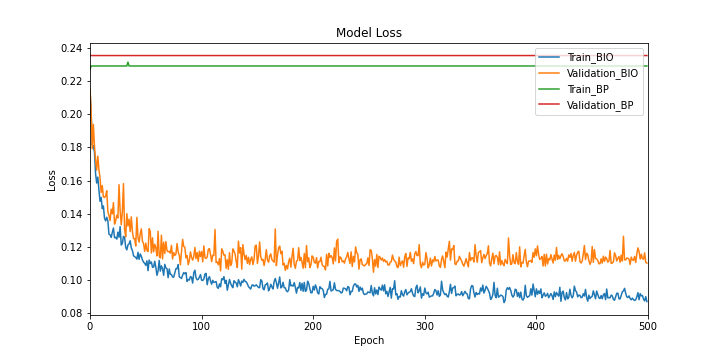

<IPython.core.display.Javascript object>


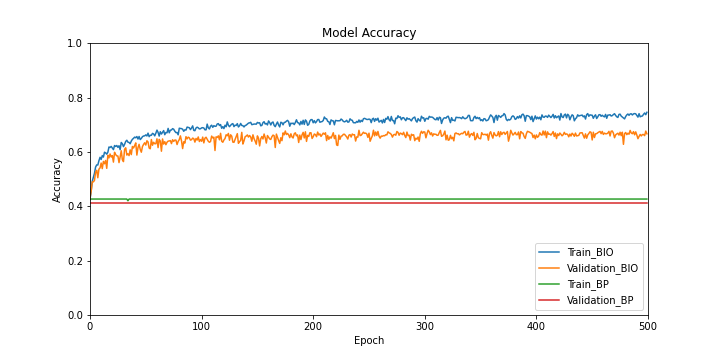

In [103]:
bio_history = bio_logs.history
bp_history = bp_logs.history

plt.figure(figsize=(10, 5))
plt.plot(bio_history['loss'])
plt.plot(bio_history['val_loss'])

plt.plot(bp_history['loss'])
plt.plot(bp_history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(0, 500)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_BP', 'Validation_BP'], loc='upper right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(bio_history['acc'])
plt.plot(bio_history['val_acc'])

plt.plot(bp_history['acc'])
plt.plot(bp_history['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.xlim(0, 500)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_BP', 'Validation_BP'], loc='lower right')
plt.show()

## Weights

<IPython.core.display.Javascript object>


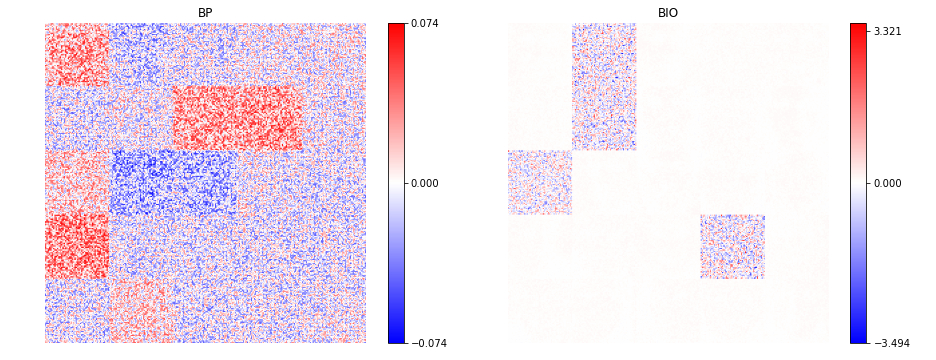

In [100]:
# %matplotlib inline
# %matplotlib notebook

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].set_title('BP')
ax[1].set_title('BIO')
bp_weights = bp_model.layers[0].get_weights()[0].T
draw_weights(bp_weights, Kx, Ky, ax[0])
draw_weights(synapses, Kx, Ky, ax[1])
plt.tight_layout()
plt.show()

### Control Test: A model with only one output layer
If a model with only one output layer performs on paar with BIO, this means the images themselves are as representative as the biological hidden neurons.

In [101]:
control_model = keras.Sequential([
    layers.Input(shape=(N_in)),
    layers.BatchNormalization(),
    layers.Dense(Nc, activation='softmax')
])
control_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
control_logs = control_model.fit(x_train0, y_train, validation_data=(x_val0, y_val), batch_size=385, epochs=500, verbose=0)

In [102]:
print("Final Training Accuracy:", control_logs.history['acc'][-1])
print("Final Validation Accuracy:", control_logs.history['val_acc'][-1])

Final Training Accuracy: 0.4266412
Final Validation Accuracy: 0.41086498
